In [10]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import matplotlib.patheffects as pe
# for exporting things as mat for matlab
import scipy.io

# For linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# For kernel covariance matrix
import seaborn as sns

In [24]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#E37A1B','#FFD966','#8EB85A','#A3E8F3','#376C72','#9F8BAD',"#ED9CCB", "#615C3B",'#FF9840',"#9F755F"] #Color scheme
# USGS_site_id = ['03339000','03346500','03381495','05446500','05447500','05586300','05595000','05599490', 'yippee', 'yahoo']
markers = ['s', 'o','^', '*', 'X','>','d','<','v','+']
labels = list(string.ascii_uppercase)

MATLAB_filepath = "GVR_LISST"


plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

# Load USGS site data and SAC

In [12]:

import glob

lisst_dir = "LISST_ABS_USGS"
lisst_files = glob.glob(f"{lisst_dir}/*.csv")
print(f"📁 Found {len(lisst_files)} CSV files")
alpha_site_id = labels[0:len(lisst_files)]

lisst_data_dict = {}

# Prioritized variants for each column
column_priority = {
    "ABS": ["ABS (All)", "ABS"],
    "Turb": ["Turb (All)", "Turbidity"],  # ← optional now
    "SSC": ["SSC (All)", "Total SSC"],
    "Fines": ["Fines"],
    "Sands": ["Sands"],
    "Date": ["Date"]
}

for i, file_path in enumerate(lisst_files):
    fname = file_path.split("/")[-1]
    site_id = fname.replace(".csv", "")
    print(f"\n📄 Processing: {fname}")

    try:
        # Step 1: Read only column headers
        df_head = pd.read_csv(file_path, nrows=0)
        file_cols = df_head.columns.tolist()
        print(f"🔍 Columns found: {file_cols}")

        # Step 2: Select available columns
        selected_cols = {}
        for std_name, variants in column_priority.items():
            for variant in variants:
                if variant in file_cols:
                    selected_cols[variant] = std_name
                    break  # take the first available option

        # Step 3: Check for required columns (excluding Turb)
        required_columns = {"Date", "ABS", "SSC", "Fines", "Sands"}
        found_columns = set(selected_cols.values())

        if not required_columns.issubset(found_columns):
            print(f"⚠️ Skipping {fname}: Missing required columns → {required_columns - found_columns}")
            continue

        # Step 4: Read available columns
        df = pd.read_csv(file_path, usecols=selected_cols.keys())

        # Step 5: Rename to consistent names
        df = df.rename(columns=selected_cols)

        # Step 6: If Turb missing, add column with NaNs
        if "Turb" not in df.columns:
            df["Turb"] = np.nan
            print(f"ℹ️ Note: 'Turb' not found in {fname}, filled with NaN.")

        # Step 7: Store in dictionary
        lisst_data_dict[alpha_site_id[i]] = {'site_id': site_id,
                                             'datetime': df["Date"],
                                             'ABS': df["ABS"],
                                             "SSC": df["SSC"],
                                             'fines': df["Fines"],
                                             'sands': df["Sands"],
                                             'turb': df['Turb']}
        print(f"✅ Loaded {fname} with {len(df)} rows")

    except Exception as e:
        print(f"❌ Error reading {fname}: {type(e).__name__} — {e}")


📁 Found 7 CSV files

📄 Processing: Missouri_River_NebraskaCity_06807000.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Missouri_River_NebraskaCity_06807000.csv with 25 rows

📄 Processing: Rock_Creek_01648010.csv
🔍 Columns found: ['Date', 'ABS', 'Turbidity', 'Total SSC', 'Fines', 'Sands']
✅ Loaded Rock_Creek_01648010.csv with 68 rows

📄 Processing: Elwha_River_12046260.csv
🔍 Columns found: ['Date', 'ABS', 'ABS (All)', 'Turbidity', 'Turb (All)', 'Total SSC', 'SSC (All)', 'Fines', 'Sands']
✅ Loaded Elwha_River_12046260.csv with 73 rows

📄 Processing: Sacramento_River_11447650.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Sacramento_River_11447650.csv with 22 rows

📄 Processing: Illinois_River_05586300.csv
🔍 Columns found: ['Date', 'Depth', 'ABS', 'Turbidity', 'Total SSC', 'Percent Finer', 'Fines', 'Sands']
✅ Loaded Illinois_River_05586300.csv with 25 r

# Functions

## Gaussian Process

In [13]:
def GP(SAC_m, SSC_m, p, SAC_range = [None,None], SAC_log=False, SSC_log=False, hyperparams = -999):
    #assuming don't want log value (and pass regular values)
   
    # Calculate range for model run 
        #safety measure if not put in correct order and if passed as list with wiggle room
    if SAC_range != [None,None]:
        min_SAC = np.array(SAC_range).min()-(0.1*np.array(SAC_range).min())
        max_SAC = np.array(SAC_range).max()+(0.1*np.array(SAC_range).max())
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()  

     #option to pass in hyperparameters -> it is a 2 element list where the first is the rbf (squared exponentia - l) length scale, the second is the white noise level
    # Combination of RBF and whitekernel set to optimize hyperparameters
    x_range = max_SAC-min_SAC
    min_l = x_range * 0.1
    max_l = x_range * 0.75
    
    noise_std = np.std(SSC_m)

    # Prevent zero or extremely small noise std
    noise_std = max(noise_std, 1e-6)

    low = (0.01 * noise_std) ** 2
    high = (0.5 * noise_std) ** 2

    # # Swap if bounds are inverted (just in case)
    # if low > high:
    #     low, high = high, low

    # # Ensure bounds are not equal or too close
    # min_gap = 1e-6
    # if abs(high - low) < min_gap:
    #     high = low + min_gap

    # print(f"Length scale bounds: min_l={min_l}, max_l={max_l}")

    # print(f"Noise bounds: low={low}, high={high}")

    if hyperparams == -999:
        kernel = RBF(length_scale=x_range * 0.1, length_scale_bounds=(min_l, max_l)) + WhiteKernel(noise_level=noise_std**2, noise_level_bounds=(low, high))
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")
  

    #Set variables for training
    X = np.array(SAC_m).reshape(-1,1)
    y = SSC_m #hand made for scale 2
    
    #Change to log based if output desired is in log and calucate range
    if SAC_log == True:
        min_SAC = np.log10(min_SAC)
        max_SAC = np.log10(max_SAC)
        X = np.log10(np.array(SAC_m).reshape(-1,1))
    if SSC_log == True:
         y = np.log10(SSC_m) 

    #Make range for SAC prediction
    SAC_pred = np.linspace(min_SAC,max_SAC,p)

    #Create model from training data
    # https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
    gaussian_proccess = GaussianProcessRegressor(kernel=kernel, normalize_y = True, alpha=1e-5 )
    gpr = gaussian_proccess.fit(X,y)
    gaussian_proccess.kernel_
    try:
        GP_score = gpr.score(X, y)
    except ValueError:
        GP_score = np.nan
    GP_logmarg = gpr.log_marginal_likelihood()
    
    #Make predicted model from kernel
    [Y_pred, std] = gpr.predict(SAC_pred.reshape(-1, 1) , return_std = True)

    # how to get kernel with optimized hyperparameters: gaussian_proccess.kenerl_.theta
    return (SAC_pred, Y_pred, std, GP_score, GP_logmarg, gaussian_proccess)


## Covariance matrix to correlation matrix

In [14]:
def cov_to_cor(cov):
    # get diagonal elements from covaraince matrix
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v,v)
    cor = cov/outer_v
    cor[cov == 0] = 0
    return cor

### make kernel matrix function of k(xi, xj)

In [15]:
# make my own kernel matrix function of k(xi,xj)

def rbf_ker(x,y,l):
    k = math.exp(- math.dist([x],[y]) / (2*l**2) )
    return k

# Linear fits

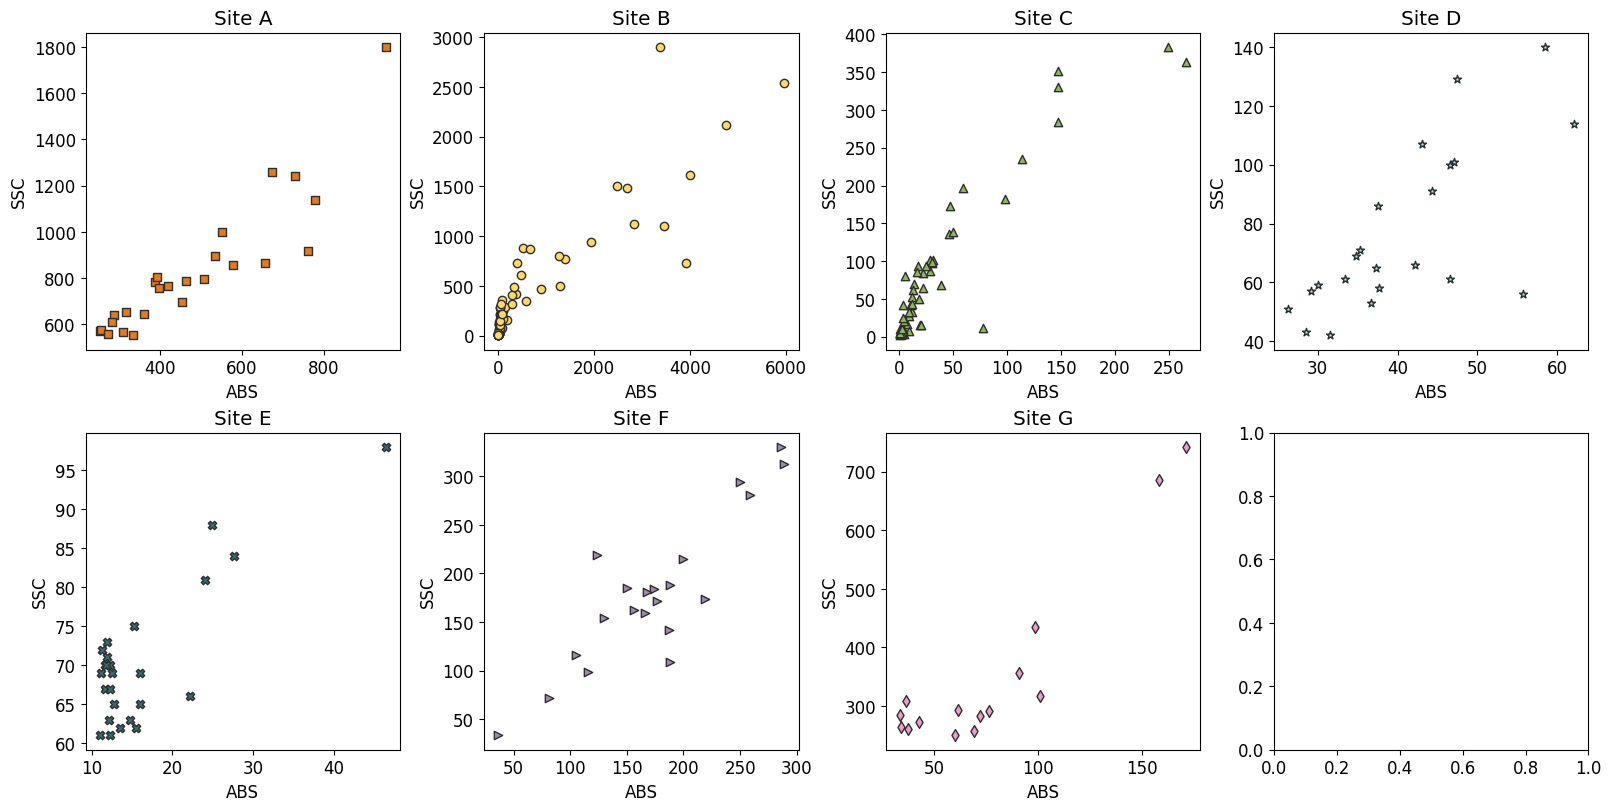

In [16]:
x_key = "ABS"
y_key = "SSC"
# 'ABS', 'SSC', 'turb', 'fines', 'sands'

n_sites = len(alpha_site_id)
ncols = 4  # you can change this based on how wide you want the figure
nrows = int(np.ceil(n_sites / ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4), constrained_layout=True)
axs = axs.flatten()

for i, id in enumerate(alpha_site_id):
    ax = axs[i]
    colr = colr_sc[i]
    mod = lisst_data_dict.get(id)

    x = np.array(mod[x_key])
    y = np.array(mod[y_key])

    valid_mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[valid_mask].reshape(-1, 1)
    y = y[valid_mask].reshape(-1, 1)

    if x.size == 0 or y.size == 0:
        ax.set_title(f"Site {id} (no data)")
        continue
    else:
        ax.set_title(f"Site {id}")

    ax.scatter(x, y, color=colr, marker=markers[i % len(markers)], edgecolors='#2E2E2E', zorder=1)

    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)

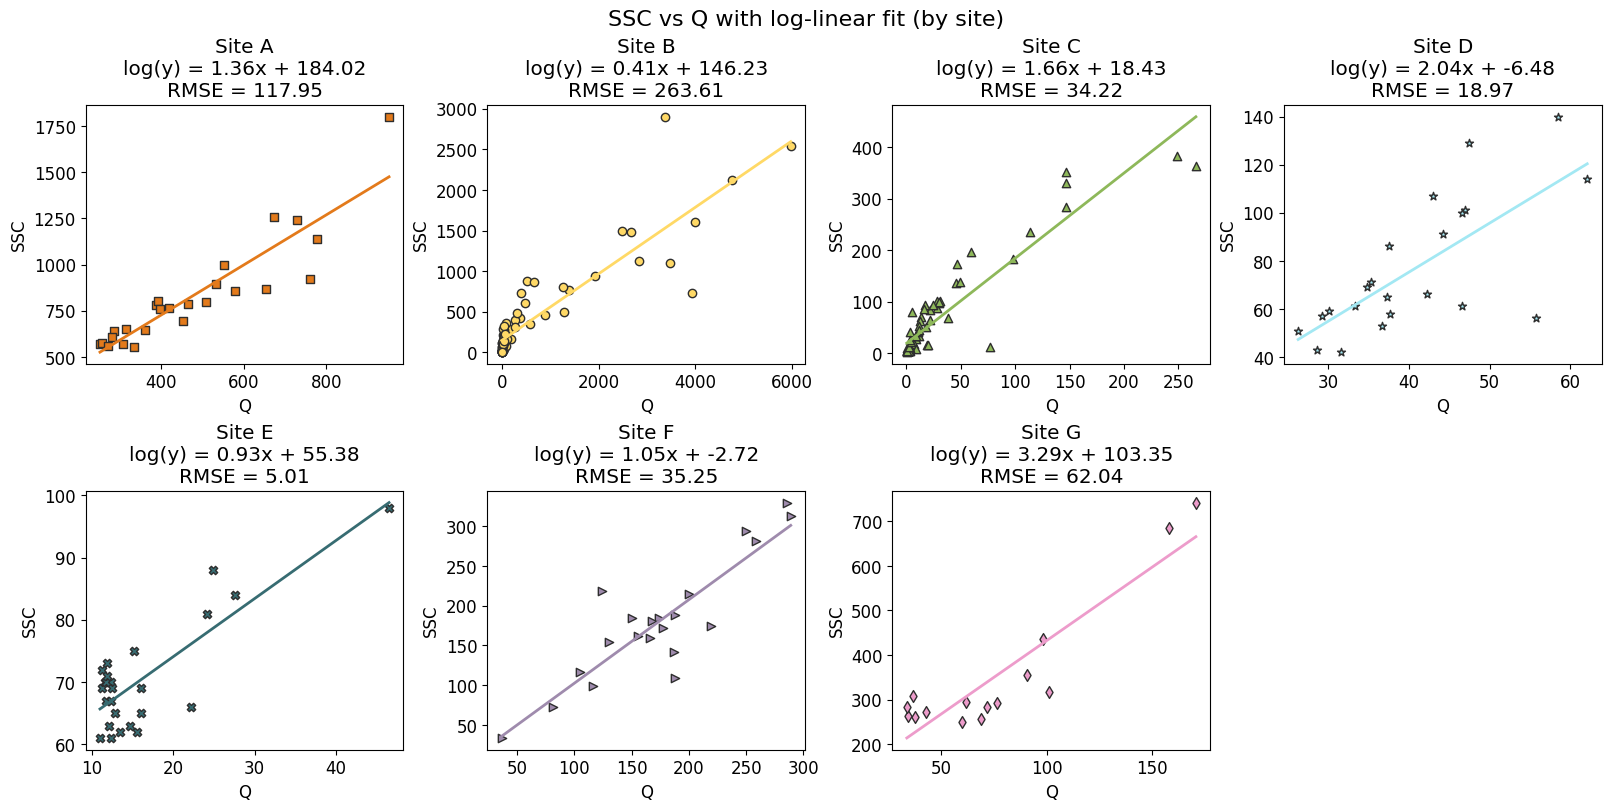

In [17]:
x_key = "ABS"
y_key = "SSC"
# 'total_p', 'nitrate', 'Q', 'dQdt', 'ssc'

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4), constrained_layout=True)
axs = axs.flatten()

for i, id in enumerate(alpha_site_id):
    ax = axs[i]
    colr = colr_sc[i]
    mod = lisst_data_dict.get(id)

    x = np.array(mod[x_key])
    y = np.array(mod[y_key])


    valid_mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[valid_mask].reshape(-1, 1)
    y = y[valid_mask].reshape(-1, 1)

    if x.size == 0 or y.size == 0:
        ax.set_title(f"Site {id} (no data)")
        continue

    # Scatter plot
    ax.scatter(x, y, color=colr, marker=markers[i % len(markers)], edgecolors='#2E2E2E', zorder=1)

    # Fit regression
    # log_y = np.log(y)
    log_y = y
    model = LinearRegression()
    model.fit(x, log_y)
    log_y_pred = model.predict(x)

    sorted_idx = np.argsort(x.ravel())
    x_sorted = x[sorted_idx]
    log_y_pred_sorted = log_y_pred[sorted_idx]

    slope = model.coef_[0, 0]
    intercept = model.intercept_[0]
    rmse = np.sqrt(mean_squared_error((log_y), (log_y_pred)))

    ax.plot(x_sorted, (log_y_pred_sorted), color=colr, linewidth=2)

    # Log scale and titles
    # ax.set_yscale('log')
    ax.set_title(f"Site {id}\nlog(y) = {slope:.2f}x + {intercept:.2f}\nRMSE = {rmse:.2f}")
    ax.set_xlabel('Q')
    ax.set_ylabel('SSC')

# Turn off any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("SSC vs Q with log-linear fit (by site)", fontsize=16)
plt.show()


A
Missouri_River_NebraskaCity_06807000
B
Rock_Creek_01648010
C
Elwha_River_12046260
D
Sacramento_River_11447650
E
Illinois_River_05586300
F
Cherry_Creek_06713000
G
Missouri_River_StCharles_06935965


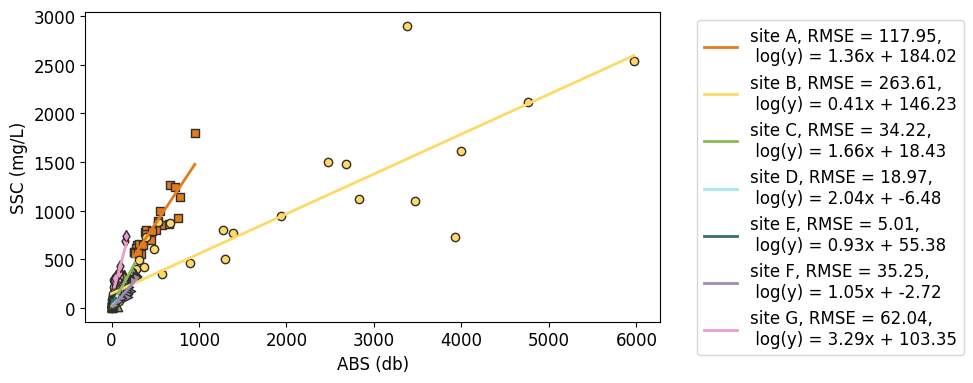

In [18]:
plt.figure(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    print(id)
    colr = colr_sc[i]
    mod = lisst_data_dict[id]
    print(mod['site_id'])
    
    # Scatter plot
    x = np.array(mod['ABS']).reshape(-1, 1)
    # print(x)
    y = np.array(mod['SSC']).reshape(-1, 1)
    plt.scatter(x, y, color=colr, marker=markers[i], edgecolors='#2E2E2E', zorder=1)
    
    # Use log of y for linear regression
    # log_y = np.log(y)
    log_y = y
    
    # Linear regression
    model = LinearRegression()
    model.fit(x, log_y)
    log_y_pred = model.predict(x)
    
    # Sort the data for plotting
    sorted_indices = np.argsort(x.ravel())
    x_sorted = x[sorted_indices]
    log_y_pred_sorted = log_y_pred[sorted_indices]
    
    # Calculate the slope and intercept
    slope = model.coef_[0, 0]
    intercept = model.intercept_[0]
    
    # Calculate RMSE using log values
    log_rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error((log_y), (log_y_pred)))
    
    # Plot the fitted line in the original scale
    plt.plot(x_sorted, (log_y_pred_sorted), linewidth=2, color=colr, 
             label=f'site {id}, RMSE = {rmse:.2f}, \n log(y) = {slope:.2f}x + {intercept:.2f}')

# plt.yscale('log')
plt.xlabel('ABS (db)')
plt.ylabel('SSC (mg/L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/linear_fit.png' , dpi=500) 

plt.show()

# Gaussian baseline models

## uses all grabs samples at given site to train a model for that site

A: l = 328.83, nl = 7.88
B: l = 2252.01, nl = 35.45
C: l = 119.15, nl = 0.84
D: l = 18.07, nl = 0.55
E: l = 3.55, nl = 0.28
F: l = 59.52, nl = 0.56
G: l = 56.65, nl = 2.21


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 7.878892159999999. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 35.4503160899654. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8404178269844249. Decreasing the bound and calling fit again may fin

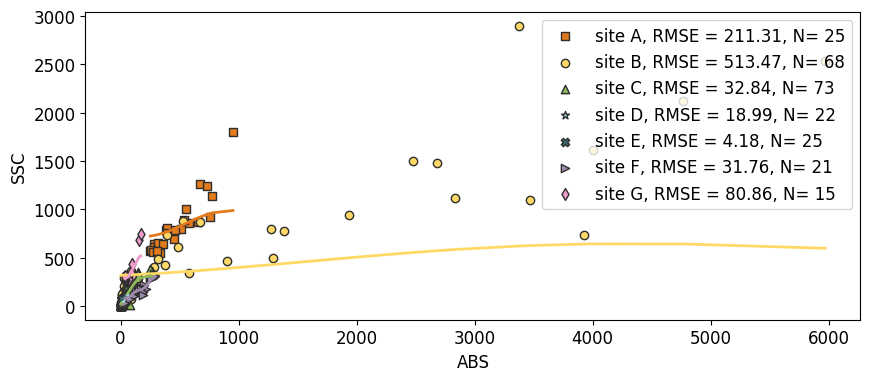

In [19]:
model_dictionary = {}

x_key = 'ABS'
y_key = 'SSC'

plt.figure(figsize=(10, 4))


#Run GP using all data
# for by site, optimizing hyperparameters -> stored by USGS site name
for i, id in enumerate(alpha_site_id):
    site_data = lisst_data_dict[id]
    xdata = site_data[x_key].to_numpy()
    ydata = site_data[y_key].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model = GP(xdata, ydata, p)  
    # obtains length scales of rbf and noise level for white kernel from trained GP model
    l,nw = np.exp(GP_model.kernel_.theta)
    print(f'{id}: l = {np.round(l,2)}, nl = {np.round(nw,2)}')
    # important ypred and ydata are sorted same order wrt xdata
    ypred, std_pred = GP_model.predict(xdata.reshape(-1, 1), return_std=True, return_cov=False)
    MSE_all = np.square(np.subtract(ydata,ypred)).mean() 
    rmse_all = math.sqrt(MSE_all)

    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))

    # Sort xdata and reorder ypred to match
    sorted_indices = np.argsort(xdata)
    x_sorted = np.array(xdata)[sorted_indices]
    y_sorted = np.array(ypred)[sorted_indices]
    std_sorted = np.array(std_pred)[sorted_indices]

    num_samp = len(x_sorted)

    plt.scatter(xdata, ydata, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', zorder=1, label=f'site {id}, RMSE = {rmse_all:.2f}, N= {num_samp}')
    plt.plot(x_sorted, y_sorted, color=colr_sc[i], linewidth=2)   
    # plt.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, color=colr_sc[i], alpha=0.2)

    plt.xlabel(x_key)
    plt.ylabel(y_key)
    plt.legend()
    # plt.savefig(f'figures/GP_baselinemodel.png', dpi=500)

    model_dictionary[id] = {    'hyperparams': {
                                    'rbf_l' : l,
                                    'noise_l' : nw,
                                },
                                'num_samp' : num_samp,
                                'x': xdata,
                                'y': ydata,
                                'n_pred': ypred,
                                'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
                                # 'scores': [GP_score_all, GP_logmarg_all, r_score_all, rmse_all],
                                'scores': {
                                    'GP_score':GP_score_all, 
                                    'GP_logmarg':GP_logmarg_all,
                                    'r_score': r_score_all, 
                                    'rmse' : rmse_all, 
                                    'std': std_pred
                                },
                                'model': GP_model
                                }
    
plt.show()


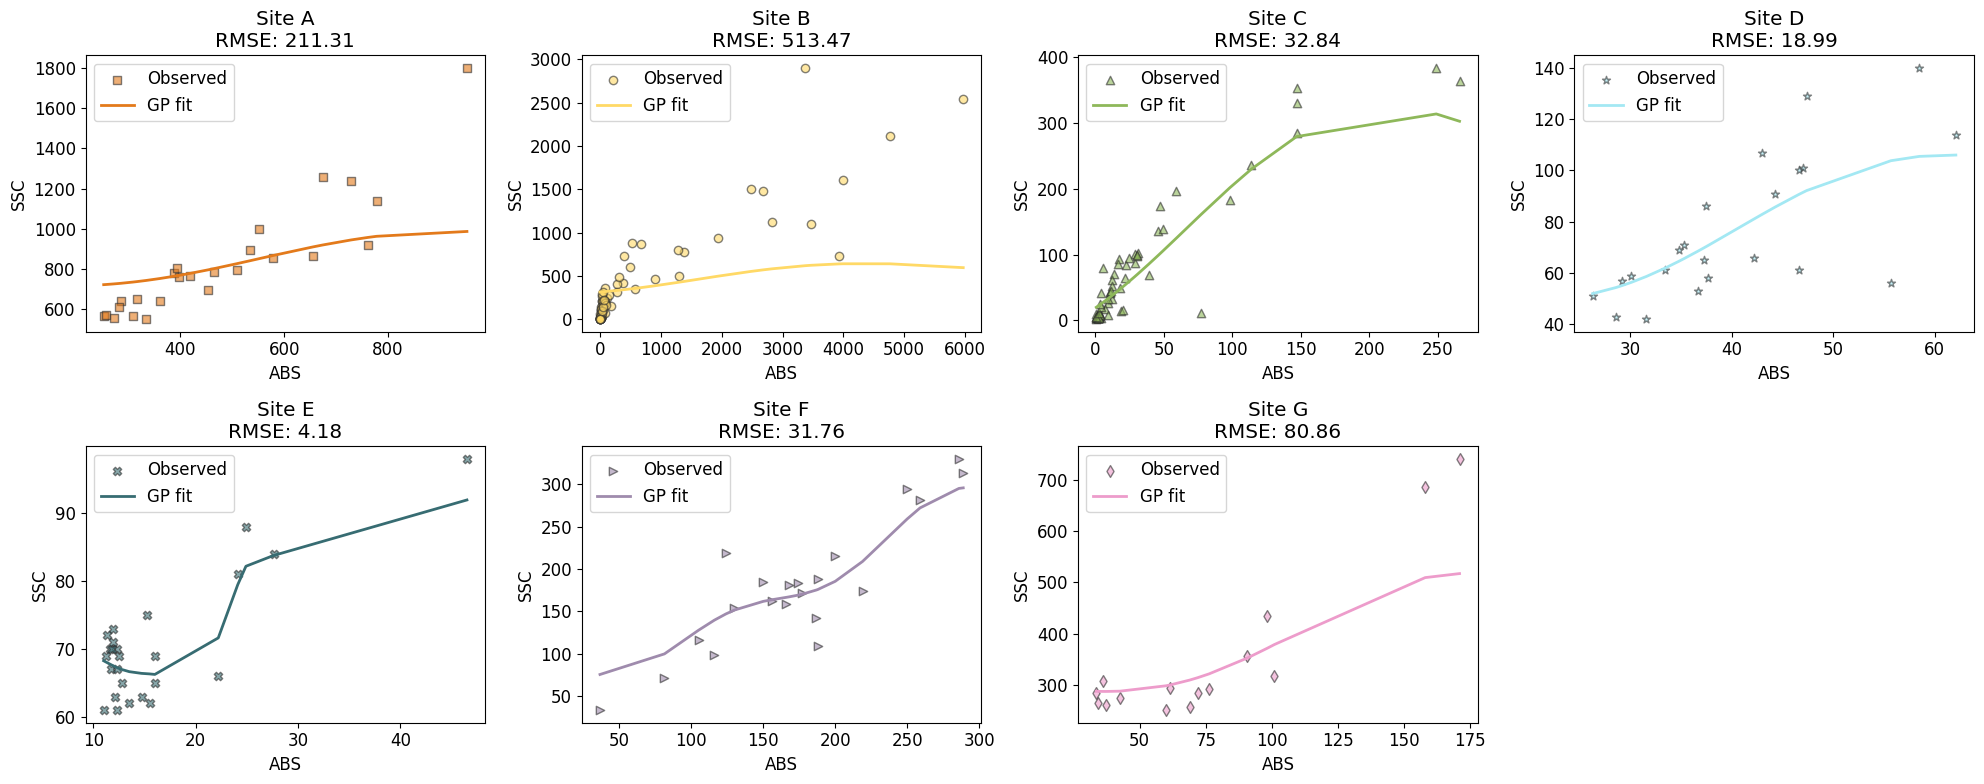

In [20]:
x_key = 'ABS'
y_key = 'SSC'

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)

    ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## All kernels on all sites permutations

In [21]:
# Initialize the new dictionary
cross_prediction_dictionary = {site_id: {} for site_id in alpha_site_id}

# Loop through each combination of test and model sites
for model_id in alpha_site_id:
    for site_id in alpha_site_id:
        # Get the model from the model_dictionary
        GP_model = model_dictionary[model_id]['model']

        # Get the test site data
        test_data = lisst_data_dict[site_id]
        x_test = test_data[x_key].to_numpy()
        y_test = test_data[y_key].to_numpy()

        # Use the model to predict SSC for the test data
        y_pred, std_pred = GP_model.predict(x_test.reshape(-1, 1), return_std=True)

        # Calculate scores
        MSE = np.square(np.subtract(y_test, y_pred)).mean()
        rmse = math.sqrt(MSE)
        r_score = GP_model.score(y_pred.reshape(-1, 1), y_test.reshape(-1, 1))

        # Store the results in the new dictionary
        cross_prediction_dictionary[site_id][model_id] = {
            'hyperparams': {
                'rbf_l' : l,
                'noise_l' : nw,
            },
            'x': xdata,
            'y': ydata,
            'n_pred': ypred,
            'scores': {
                'r_score': r_score, 
                'rmse' : rmse, 
                'std': std_pred
            },
            'model': GP_model
                                           
        }

In [22]:

print("RMSE for all sites with different models used to predict on it:")

for site_id in alpha_site_id:
    print(f"\nTest Site: {site_id}")
    # base_r, base_rmse = model_dictionary[site_id]['scores'][2:4]
    # print(f"  Baseline from Site {site_id}: RMSE = {base_rmse:.2f}; R = {base_r:.2f}")

    for i, model_id in enumerate(alpha_site_id):
        rmse = cross_prediction_dictionary[site_id][model_id]['scores']['rmse']
        r = cross_prediction_dictionary[site_id][model_id]['scores']['r_score']
        print(f"  Model from Site {model_id}: RMSE = {rmse:.2f}")


RMSE for all sites with different models used to predict on it:

Test Site: A
  Model from Site A: RMSE = 211.31
  Model from Site B: RMSE = 548.03
  Model from Site C: RMSE = 758.24
  Model from Site D: RMSE = 803.54
  Model from Site E: RMSE = 809.09
  Model from Site F: RMSE = 686.34
  Model from Site G: RMSE = 549.44

Test Site: B
  Model from Site A: RMSE = 657.37
  Model from Site B: RMSE = 513.47
  Model from Site C: RMSE = 686.74
  Model from Site D: RMSE = 688.32
  Model from Site E: RMSE = 691.42
  Model from Site F: RMSE = 639.01
  Model from Site G: RMSE = 588.99

Test Site: C
  Model from Site A: RMSE = 675.11
  Model from Site B: RMSE = 269.11
  Model from Site C: RMSE = 32.84
  Model from Site D: RMSE = 87.37
  Model from Site E: RMSE = 91.02
  Model from Site F: RMSE = 80.96
  Model from Site G: RMSE = 256.91

Test Site: D
  Model from Site A: RMSE = 652.20
  Model from Site B: RMSE = 243.56
  Model from Site C: RMSE = 22.67
  Model from Site D: RMSE = 18.99
  Model fro

# optimal sample selection

## Creating the covariance matrix for each site

### Compute matrix for each site, specifiying n points

In [21]:
# Initialize the dictionary to store results
correlation_matrices = {}
n_range = [20, 25, 50, 100]  # Number of points for covariance matrix

# Loop through all sites using alpha_site_id
for id in alpha_site_id:
    # initialize dictionary for site
    correlation_matrices[id] = {}
    # Read in values from the past dictionaries
    mod = model_dictionary[id]
    x = mod['x']
    y = mod['y']
    pred_x = mod['p_pred'][0]
    pred_y = mod['p_pred'][1]
    rmse = mod['scores']
    l = mod['hyperparams']['rbf_l']
    nw = mod['hyperparams']['noise_l']

    # Sort data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    ''' 
    For n point range
    '''
    correlation_matrices[id]['n'] = {}
    for n in n_range: 
        # Make evenly spaced array of length n to predict the model with
        nx_trend = np.linspace(np.min(x_sort) - 0.05, np.max(x_sort) + 0.5, n)

        # Initialize the RBF kernel matrix
        rbf = np.zeros((n, n))

        # Compute the RBF kernel matrix
        for i, x in enumerate(nx_trend):
            for j, y in enumerate(nx_trend):
                rbf[i, j] = rbf_ker(x, y, l)

        # Add white noise to the diagonal
        wn = np.identity(n) * nw
        kernnie = rbf + wn

        # Compute the correlation matrix
        cor_mat = cov_to_cor(kernnie)

        # Store the correlation matrix in the dictionary
        correlation_matrices[id]['n'][n] = {
                'hyperparams': {
                    'rbf_l' : l,
                    'noise_l' : nw,
                },
                'cor_matrix' : cor_mat,
                'range' : nx_trend,
        }

    ''' 
    For num samples range across all sites 
    '''
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:        
        # Still using the target site readings
        samp_n = len(x_sort)

        # grab the length scales for the model site
        ker = model_dictionary[model_id]['hyperparams']
        l = ker['rbf_l']
        nw = ker['noise_l']
        # Initialize the RBF kernel matrix
        rbf = np.zeros((samp_n, samp_n))

        # Compute the RBF kernel matrix
        for i, x in enumerate(x_sort):
            for j, y in enumerate(x_sort):
                rbf[i, j] = rbf_ker(x, y, l)

        # Add white noise to the diagonal
        wn = np.identity(samp_n) * nw
        kernnie = rbf + wn

        # Compute the correlation matrix
        cor_mat = cov_to_cor(kernnie)

        # Store the correlation matrix in the dictionary
        correlation_matrices[id]['num_samp'][model_id] = {
                'hyperparams': {
                    'rbf_l' : l,
                    'noise_l' : nw,
                },
                'cor_matrix' : cor_mat,
                'range': x_sort,
                'n' : samp_n,
        }

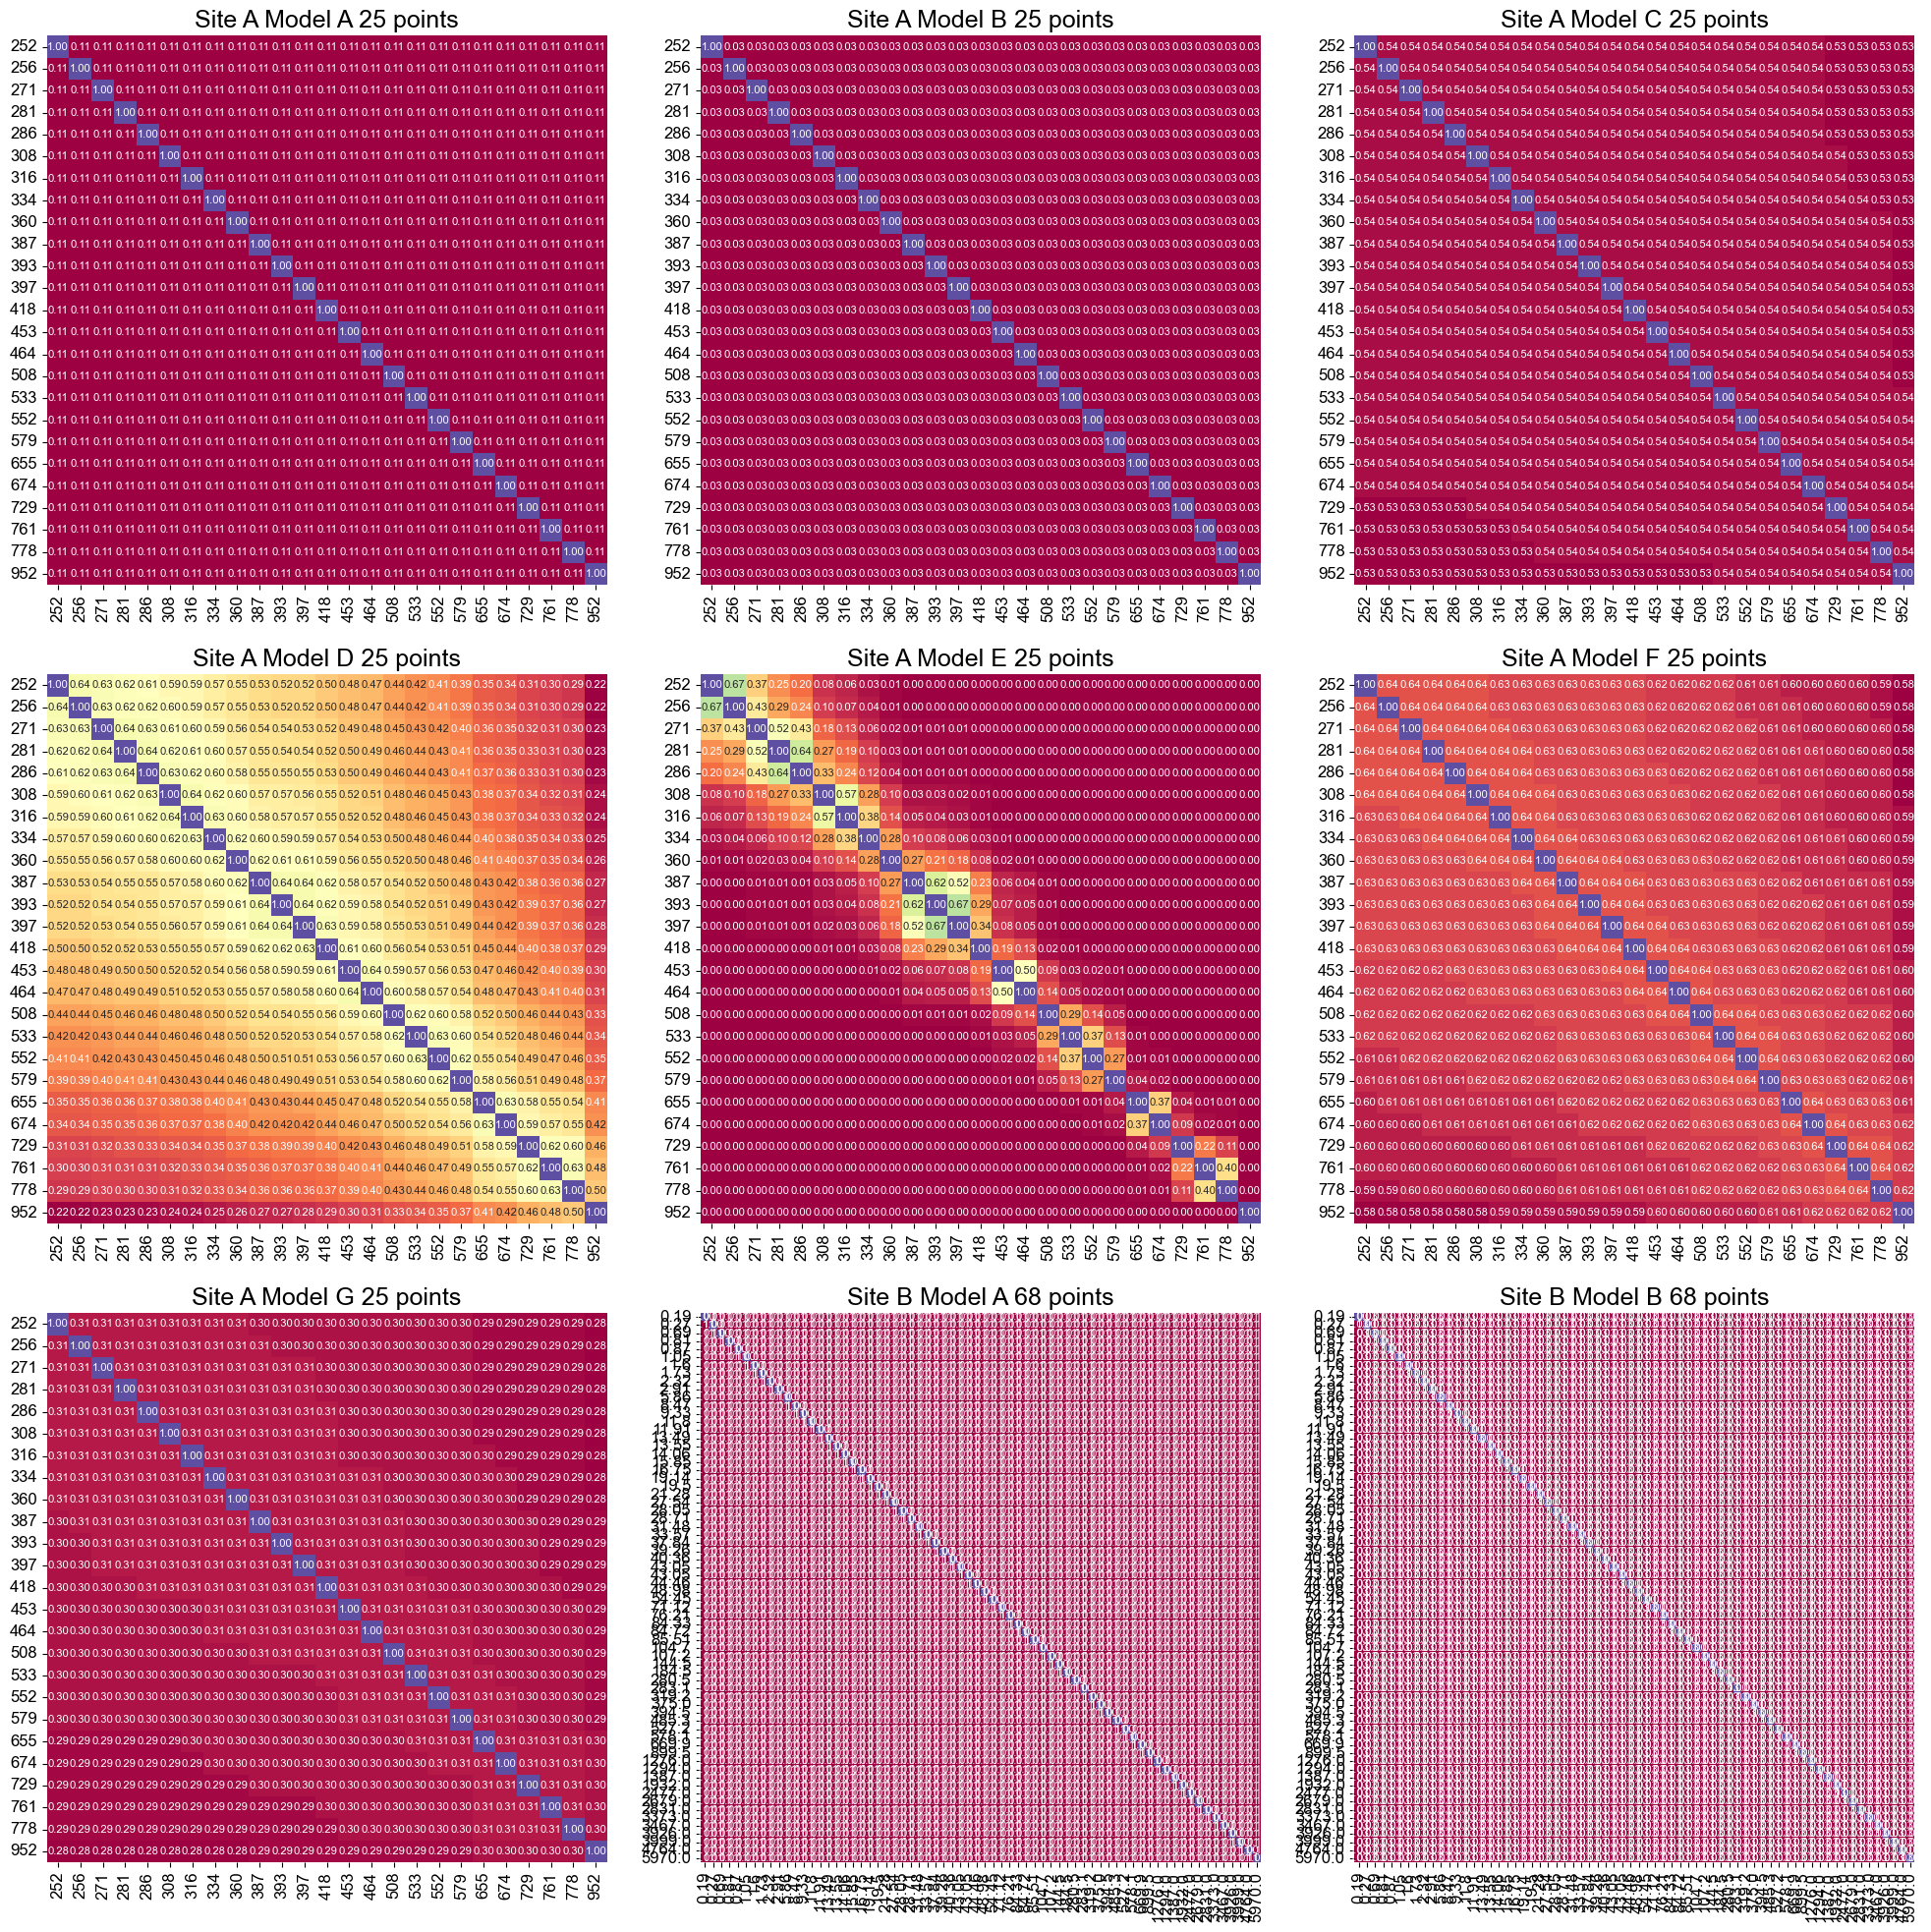

In [22]:
# Plotting the correlation matrices in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

index = 0
for id, models in correlation_matrices.items():
    for model_id, data in models['num_samp'].items():
        if index >= len(axes):
            break
        
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        mask_lt = np.triu(np.ones(cor_mat.shape), k=1).astype(bool)

        sns.set(font_scale=1.5)
        sns.heatmap(
            np.round(cor_mat, 2),
            # mask=mask_lt,
            cbar=False,
            annot=True,
            # square=True,
            cmap="Spectral",
            fmt='.2f',
            annot_kws={'size': 8},
            yticklabels=np.round(np.sort(nx_trend), 2),
            xticklabels=np.round(np.sort(nx_trend), 2),
            ax=axes[index]
        )
        axes[index].set_title(f'Site {id} Model {model_id} {len(nx_trend)} points')
        index += 1

# Hide any unused subplots
for j in range(index, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### save to ".mat" to use in matlab

In [28]:
# But really only care for the at site A, ker B and C
# import os

MATLAB_filepath = "GVR_LISST"
# do this to get the cor matrix
for id, models in correlation_matrices.items():
    print(f"data set: ")
    
    for model_id, data in models['num_samp'].items():
        print("model_id:" , model_id)
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        print(nx_trend)
        
        scipy.io.savemat(f'{MATLAB_filepath}/corr_samp{id}{model_id}.mat', {'cor_mat': cor_mat})
    scipy.io.savemat(f'{MATLAB_filepath}/xdata_samp{id}.mat', {'xdata': nx_trend})
    
    
    # save n samples too
    for n, data in models['n'].items():
        print("num_points:" , n)
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        
        scipy.io.savemat(f'{MATLAB_filepath}/corr_range{id}{n}.mat', {'cor_mat': cor_mat})
        scipy.io.savemat(f'{MATLAB_filepath}/xdata_range{id}{n}.mat', {'xdata': nx_trend})

# # This is to 
# scipy.io.savemat(f'corr_samp{model_id}.mat', {'cor_mat': cor_mat})
# scipy.io.savemat(f'SAC_samp{id}.mat', {'SAC': x_sort})

data set: 
model_id: A
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
model_id: B
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
model_id: C
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
model_id: D
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
model_id: E
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
model_id: F
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
model_id: G
[252 256 271 281 286 308 316 334 360 387 393 397 418 453 464 508 533 552
 579 655 674 729 761 778 952]
num_points: 20
num_points: 25
num_points: 50
num_points: 100
data set: 
model_id: A
[1.900e-01 2.700e-01 6.900e-01 8.100e-01 8.700e-01 1.050e+00 1.600e+00
 1.730e+00 2.320e+00 2.910e+0

## Matlab results

In [23]:
# mat_file = scipy.io.loadmat('GVR_data_code/rangeA25.mat')
# print(mat_file['A'][0])
# print(mat_file['scores'][0])

""" read sample selection and scores given arbritrary SAC range """
# range_selection = {}

# for id in alpha_site_id:
#     range_selection[id] = {}
#     for n in n_range:
#         range_selection[id][n] = {}
#         dict = range_selection[id][n]
#         mat_file = scipy.io.loadmat(f'{MATLAB_filepath}/range{id}{n}.mat')
#         dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
#         dict['score'] = mat_file['scores'][0]

""" read in sample selection out of grab samples we already have (permutating through each correlation matrix that was used to select samples) """
grabSamp_selection = {}

# selects site with grab samples used
for id in alpha_site_id:
    grabSamp_selection[id] = {}
    # cycle through kernel used
    for model_id in alpha_site_id:
        grabSamp_selection[id][model_id] = {}
        dict = grabSamp_selection[id][model_id] 
        mat_file = scipy.io.loadmat(f'{MATLAB_filepath}/samp{id}{model_id}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]


NameError: name 'MATLAB_filepath' is not defined

## Plot elbow curves

### Plot for generic range

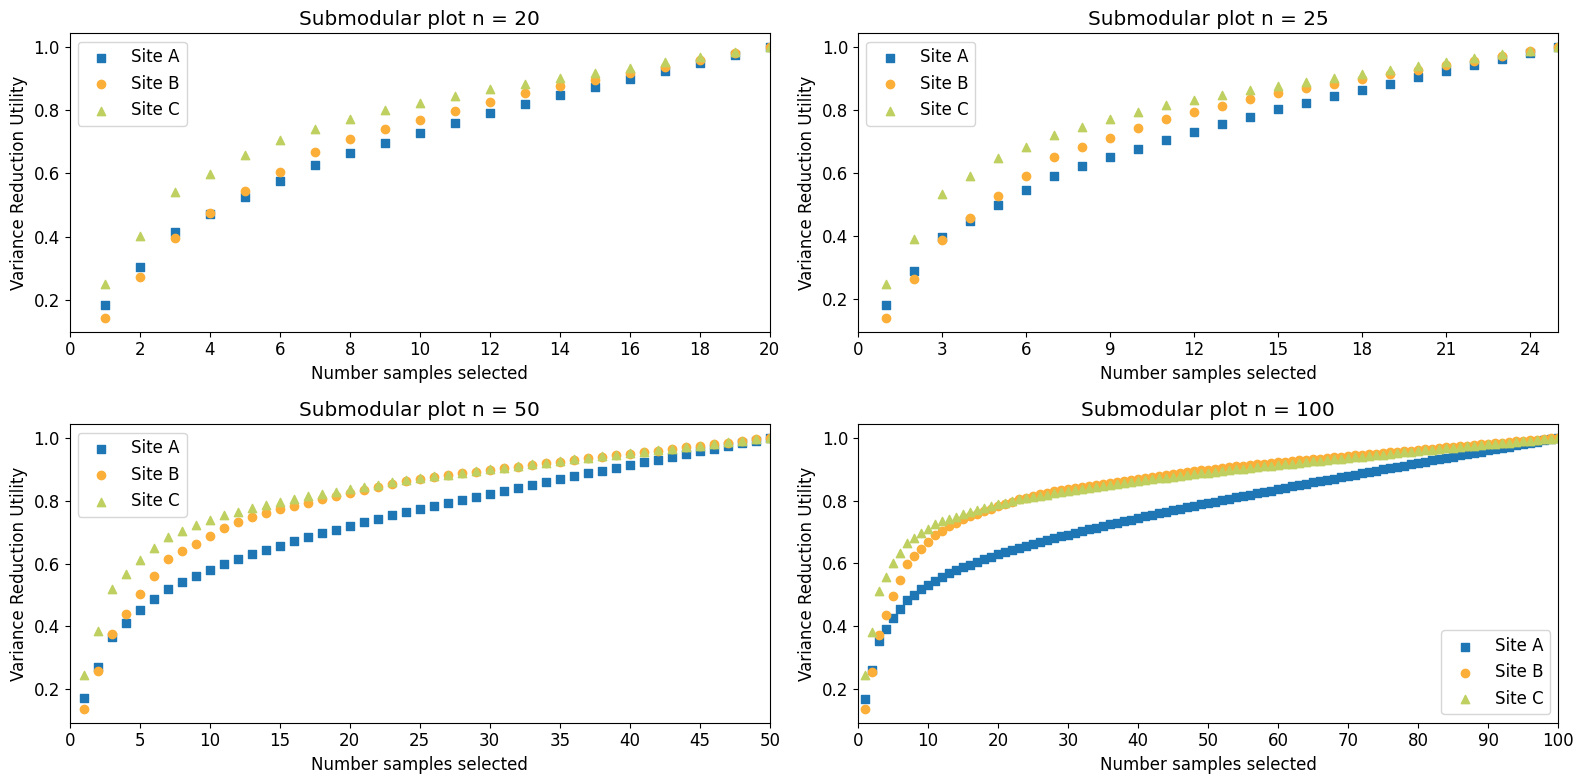

In [ ]:
# Plotting the curves with subplots for each item in n_range
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, n in enumerate(n_range):
    if idx >= len(axes):
        break  # In case n_range has more than 4 items

    ax = axes[idx]
    for i, id in enumerate(alpha_site_id):
        dict_data = range_selection[id][n]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Site {id}')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('Variance Reduction Utility')
    ax.set_title(f'Submodular plot n = {n}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if n_range has less than 4 items
for i in range(len(n_range), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

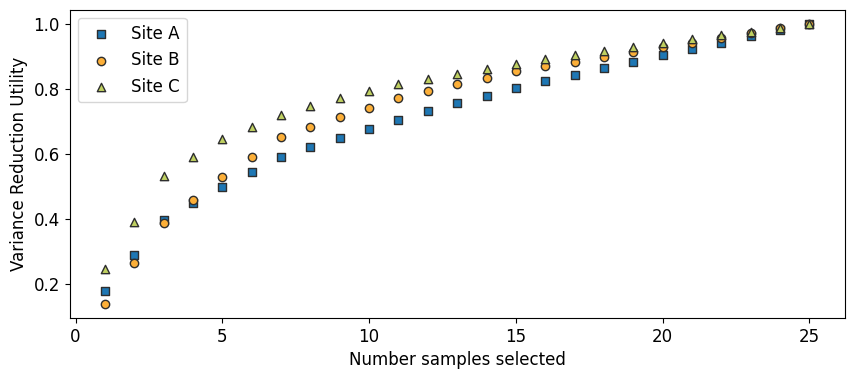

In [ ]:
# plot only for n = 25

fig, ax = plt.subplots(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    dict_data = range_selection[id][25]
    samples = dict_data['samples']
    scores = dict_data['score']
    
    # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
    x_axis = range(1, len(samples) + 1)
    
    # Plot the curve, preserving the relationship between samples and scores
    ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')


ax.set_xlabel('Number samples selected')
ax.set_ylabel('Variance Reduction Utility')
ax.legend()
# plt.savefig('figures/submod_n25.png', dpi=500)

### Plot for kernel permutation

A G plotted
B G plotted
C G plotted
D G plotted
E G plotted
F G plotted
G G plotted


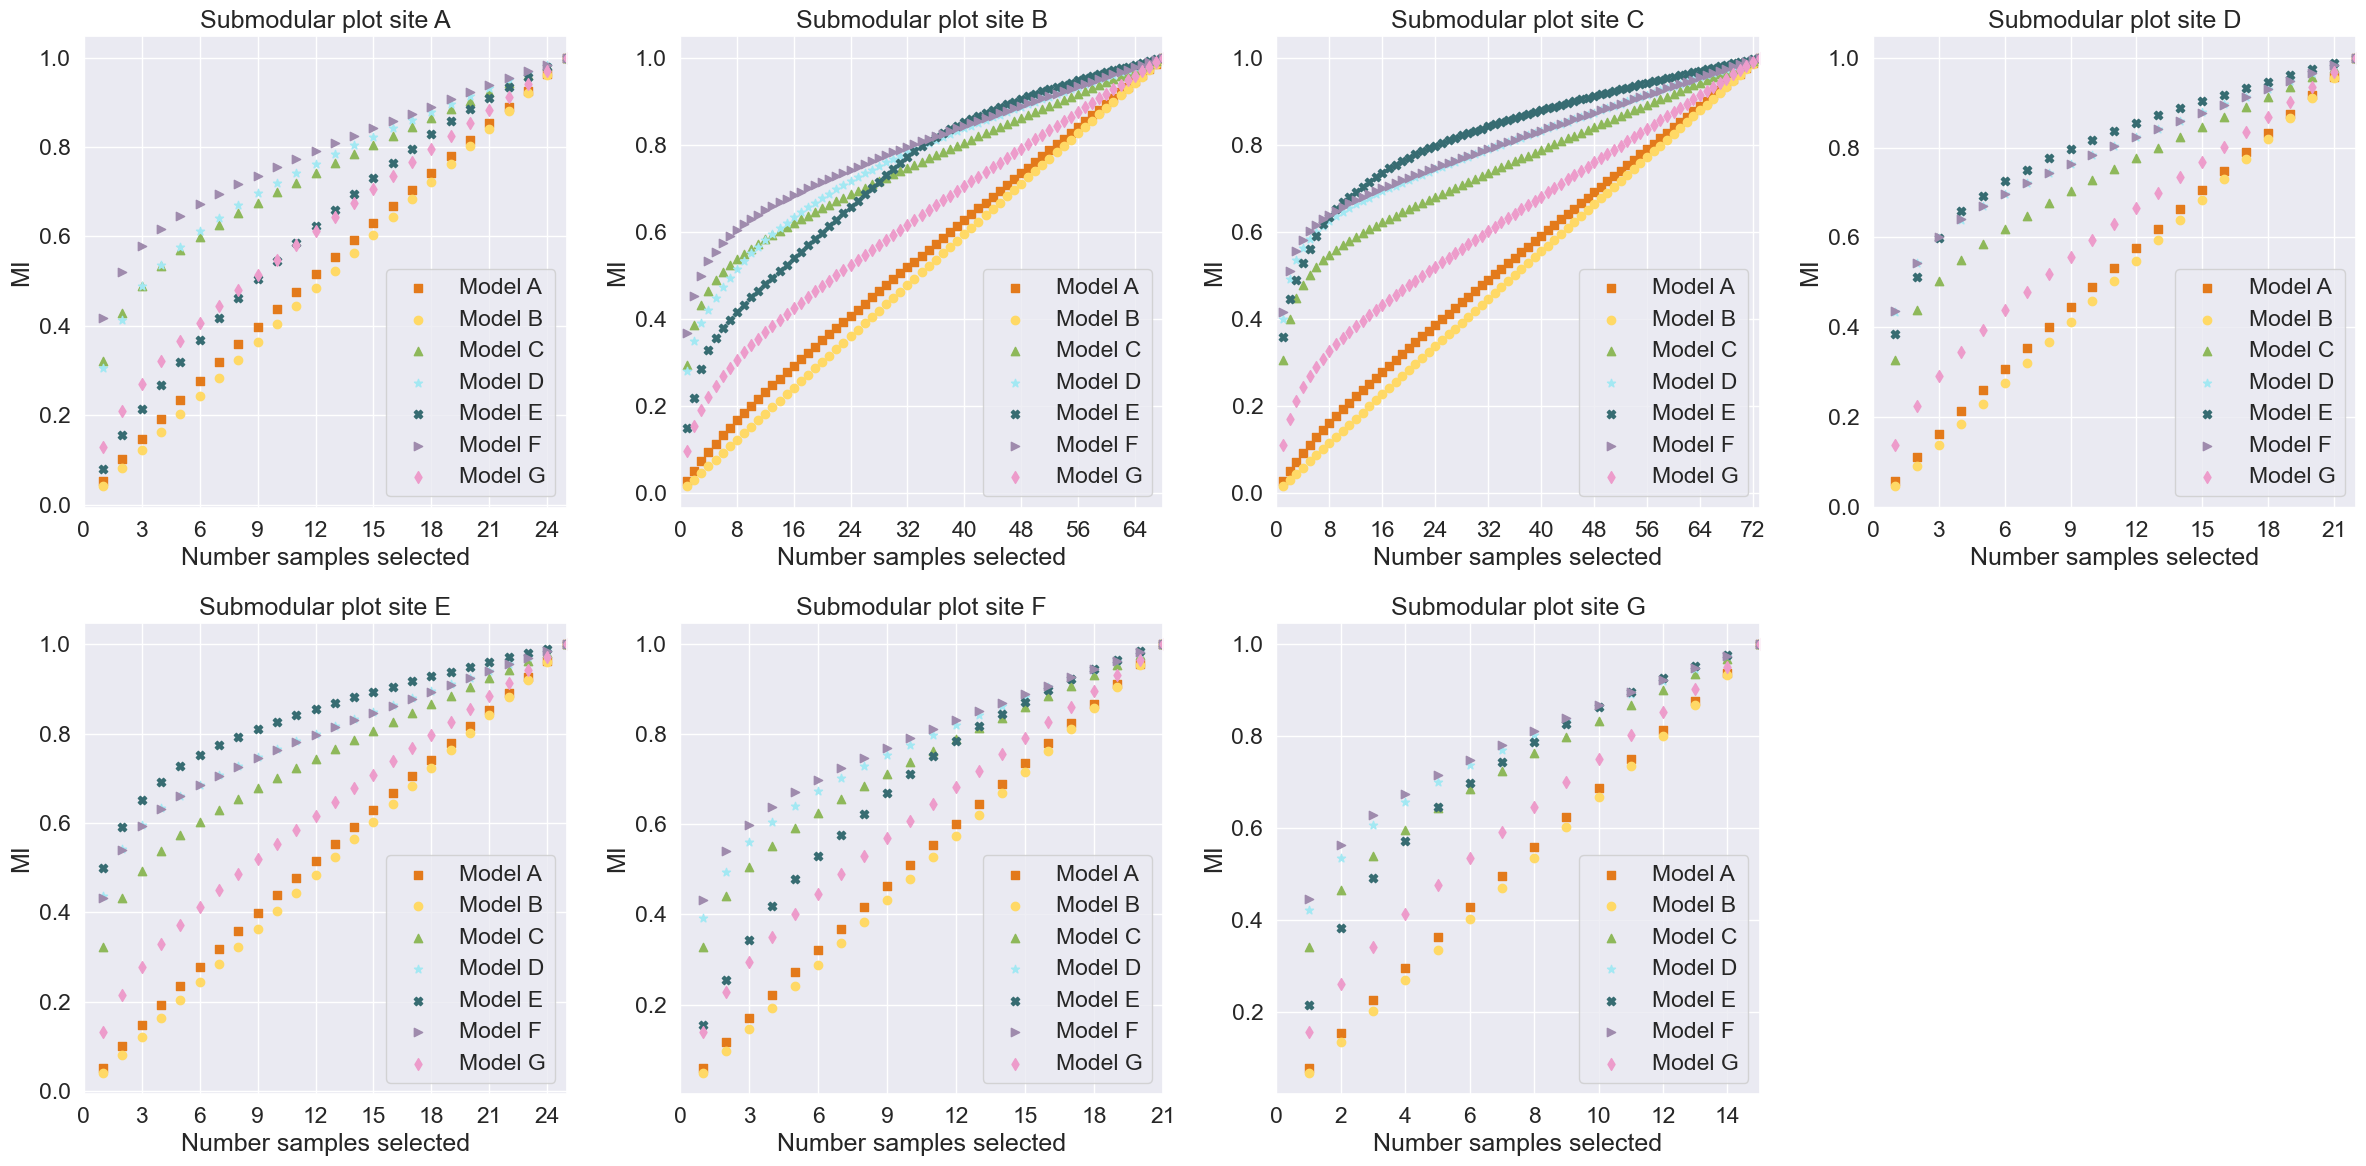

In [ ]:
# Plotting the curves with subplots for each item in n_range
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 6))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for i, model_id in enumerate(alpha_site_id):
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Model {model_id}')
    print(id, model_id, 'plotted')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('MI')
    ax.set_title(f'Submodular plot site {id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if alpha_site_id has less than 3 items
for i in range(len(alpha_site_id), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Error plots

## Calculating for optimal selection

### Start at 2 samples to train model, increase to 15, always test with remaining amount

In [ ]:
# make array of sample order 
for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for model_id in alpha_site_id:
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']

        print(samples)

[12 14  8 18  5 20  2 23  0 24  4 16 22  1 21  3 10 19  6 17  7 15  9 13
 11]
[12 13  9 16  7 18  5 20  3 22  0 24  1 23  2 21  4 19  6 17  8 15 10 14
 11]
[12 17  4 22  6 19  0 24  8  1 23 14  2 21 10 18  3 20  5 15  7 16  9 13
 11]
[10 20  3 16 23  1 24 13  7 18 21  5 12  0 15 19  8 22 17  2 14  9  6  4
 11]
[10  3  6  1 13 16 22 20 18  8 24 21 15 12 19 23 17  7 14  5  2  9  4  0
 11]
[12 18  3 22  6 24  0 14 20  1  9 23  7 16 21  2 15  4 19 10  5 17 13  8
 11]
[12 16  5 20  2 23  8 24  0 14  1 22 10 21  3 18  4 19  6 17  7 15  9 13
 11]
[33 38 25 44 20 50 15 54 11 57 28 60  6 36 64  2  9 67 18 47 66  0 27 62
  1 42 65  3 58  4 63  5 31 61  7 52 59  8 13 56 10 45 55 12 22 53 14 51
 16 40 49 17 48 19 23 46 21 43 24 41 30 35 39 26 37 29 34 32]
[33 35 37 28 41 25 44 22 47 19 50 16 52 13 55 11 57  9 60 26 62  4 39 65
  1 67  0 66  2  6 64  3 59 10 63  5 48 61  7 30 58  8 54 12 56 14 53 17
 20 51 15 49 18 45 23 46 21 43 31 42 24 40 27 38 29 36 32 34]
[31 45 14 60  8 38 65 20 51  1 67 25 5

In [ ]:
all_data = model_dictionary[site_id]
all_x = all_data['x']
all_y = all_data['y']

baseline_rmse = all_data['scores']['rmse']

In [ ]:
optimal_dictionary = {}

for i, site_id in enumerate(alpha_site_id):
    # site_data = data_dictionary[site_id]
    # all model data
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    baseline_l = all_data['hyperparams']['rbf_l']
    baseline_nw = all_data['hyperparams']['noise_l']

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]


    optimal_dictionary[site_id] = { 'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
                                    'x_sort' : all_x_sort,
                                    'y_sort' : all_y_sort,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
    }

    for model_id in alpha_site_id:
        opt_select = grabSamp_selection[site_id][model_id]

        opt_select = {
                        'opt_order' : opt_select['samples']
                    }

        opt_samp = opt_select['opt_order']
        print(f'length of samples: {len(opt_samp)}')
        # initialize optimal_dicitionary 
        optimal_dictionary[site_id][model_id] = {}
        # -4 will leave 5 test samples
        for n in np.arange(2,len(opt_samp)-4):
            opt_x = all_x_sort[opt_samp[0:n]]
            opt_y = all_y_sort[opt_samp[0:n]]
            test_x = all_x_sort[opt_samp[n:]]
            test_y = all_y_sort[opt_samp[n:]]
            # print(f'length of optx: {len(opt_x)}; n: {n}, length of test: {len(test_x)}')

            # train model using only optimal samples
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model = GP(opt_x, opt_y, p) 
            l_opt,nw_opt = np.exp(GP_model.kernel_.theta)

            # important ypred and ydata are sorted same order wrt xdata
            ypred, std_pred = GP_model.predict(test_x.reshape(-1, 1), return_std=True, return_cov=False)
            MSE_opt = np.square(np.subtract(test_y,ypred)).mean() 
            rmse_opt = math.sqrt(MSE_opt)

            r_score_opt = GP_model.score(ypred.reshape(-1, 1),test_y.reshape(-1, 1))

            optimal_dictionary[site_id][model_id][n] = {  'hyperparams': {
                                                                'rbf_l' : l_opt,
                                                                'noise_l' : nw_opt,
                                                            },
                                                            'x_train' : opt_x,
                                                            'y_train' : opt_y,
                                                            'x_test' : test_x,
                                                            'y_test' : test_y,
                                                            'n_pred' : ypred,
                                                            'p_pred' : [SAC_pred_opt, SSC_pred_opt, std_opt],
                                                            'scores': {
                                                                'GP_score':GP_score_opt, 
                                                                'GP_logmarg':GP_logmarg_opt,
                                                                'r_score': r_score_opt, 
                                                                'rmse' : rmse_opt, 
                                                                'std': std_pred,
                                                            },
                                                            'model' : GP_model,
                                                        }

length of samples: 25
Length scale bounds: min_l=4.6000000000000005, max_l=34.5
Noise bounds: low=0.0144, high=36.0
Length scale bounds: min_l=10.4, max_l=78.0
Noise bounds: low=0.3968, high=992.0
Length scale bounds: min_l=21.900000000000002, max_l=164.25
Noise bounds: low=0.58126875, high=1453.171875
Length scale bounds: min_l=27.1, max_l=203.25
Noise bounds: low=1.071856, high=2679.6400000000003
Length scale bounds: min_l=36.6, max_l=274.5
Noise bounds: low=4.886413888888889, high=12216.03472222222
Length scale bounds: min_l=40.300000000000004, max_l=302.25
Noise bounds: low=4.979383673469388, high=12448.459183673469
Length scale bounds: min_l=50.7, max_l=380.25
Noise bounds: low=5.79931875, high=14498.296875
Length scale bounds: min_l=52.6, max_l=394.5
Noise bounds: low=5.788387654320988, high=14470.969135802468
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=14.315860999999998, high=35789.6525
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=13.5463504

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 4.6000000000000005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0144. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.3968. Decreasing the bound and calling fit again may find a better value.
  

Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=11.271797959183672, high=28179.494897959183
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=11.06867288888889, high=27671.682222222225
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=11.332908984375, high=28332.2724609375
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.934987543252594, high=27337.468858131488
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.329122222222223, high=25822.80555555556
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.97964709141274, high=24949.11772853185
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.603869999999999, high=24009.675
length of samples: 25
Length scale bounds: min_l=13.4, max_l=100.5
Noise bounds: low=1.3923999999999999, high=3481.0
Length scale bounds: min_l=26.6, max_l=199.5
Noise bounds: low=2.2189555555555547, high=5547.388888888887
Length scale bounds: min_l=47.5, max_l=356.25
No

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 11.271797959183672. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 11.06867288888889. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 11.332908984375. Decreasing the bound and calling fit again may find

Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=12.216495918367348, high=30541.23979591837
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=11.446416, high=28616.039999999994
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.73146875, high=26828.671875
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.393714878892736, high=25984.287197231835
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.83411635802469, high=24585.290895061724
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.408830470914127, high=23522.07617728532
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.401085, high=23502.712499999998
length of samples: 25
Length scale bounds: min_l=11.200000000000001, max_l=84.0
Noise bounds: low=0.9506249999999999, high=2376.5625
Length scale bounds: min_l=11.200000000000001, max_l=84.0
Noise bounds: low=0.7022, high=1755.5
Length scale bounds: min_l=13.700000000000001, max_l=102.75

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 12.216495918367348. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 11.446416. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 10.73146875. Decreasing the bound and calling fit again may find a better va

Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.917510937500001, high=27293.77734375
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.307598615916955, high=25768.996539792388
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=10.005042283950619, high=25012.605709876545
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.47903434903047, high=23697.585872576175
Length scale bounds: min_l=70.0, max_l=525.0
Noise bounds: low=9.017360999999998, high=22543.402499999997
length of samples: 25
Length scale bounds: min_l=11.5, max_l=86.25
Noise bounds: low=0.42250000000000004, high=1056.25
Length scale bounds: min_l=22.5, max_l=168.75
Noise bounds: low=1.7954666666666663, high=4488.666666666666
Length scale bounds: min_l=36.6, max_l=274.5
Noise bounds: low=6.377674999999999, high=15944.187499999998
Length scale bounds: min_l=40.300000000000004, max_l=302.25
Noise bounds: low=6.6646399999999995, high=16661.6
Length scale bounds: min_l=50

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 10.307598615916955. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 10.005042283950619. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 9.47903434903047. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=267.74, max_l=2008.0500000000002
Noise bounds: low=14.818625, high=37046.5625
Length scale bounds: min_l=392.44000000000005, max_l=2943.3
Noise bounds: low=14.769850666666667, high=36924.62666666666
Length scale bounds: min_l=392.531, max_l=2943.9825
Noise bounds: low=14.612027734375001, high=36530.0693359375
Length scale bounds: min_l=392.531, max_l=2943.9825
Noise bounds: low=14.36204429065744, high=35905.110726643594
Length scale bounds: min_l=596.931, max_l=4476.9825
Noise bounds: low=39.299855555555546, high=98249.63888888886
Length scale bounds: min_l=596.931, max_l=4476.9825
Noise bounds: low=37.792126869806104, high=94480.31717451525
Length scale bounds: min_l=596.931, max_l=4476.9825
Noise bounds: low=35.91867400000001, high=89796.68500000001
Length scale bounds: min_l=596.931, max_l=4476.9825
Noise bounds: low=47.105970521541956, high=117764.92630385487
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=46.09733078512396

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 14.818625. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 14.769850666666667. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 14.612027734375001. Decreasing the bound and calling fit again may find a be

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=48.547575111111115, high=121368.93777777777
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=47.77283199432891, high=119432.07998582227
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=47.261753100950656, high=118154.38275237662
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=46.574575998263896, high=116436.43999565973
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=46.10820574760517, high=115270.51436901292
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=45.381835240000015, high=113454.58810000001
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=44.60204021530182, high=111505.10053825453
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=44.15817056213017, high=110395.42640532543
Length scale

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 48.547575111111115. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 47.77283199432891. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 47.261753100950656. Decreasing the bound and calling fit again may f

Length scale bounds: min_l=126.42000000000002, max_l=948.1500000000001
Noise bounds: low=4.859779555555557, high=12149.44888888889
Length scale bounds: min_l=126.753, max_l=950.6475
Noise bounds: low=4.756725000000001, high=11891.8125
Length scale bounds: min_l=137.853, max_l=1033.8975
Noise bounds: low=6.0823557093425595, high=15205.889273356397
Length scale bounds: min_l=138.409, max_l=1038.0674999999999
Noise bounds: low=6.080765432098766, high=15201.913580246915
Length scale bounds: min_l=267.60900000000004, max_l=2007.0675
Noise bounds: low=13.278398337950138, high=33195.995844875346
Length scale bounds: min_l=267.60900000000004, max_l=2007.0675
Noise bounds: low=12.668593999999999, high=31671.484999999997
Length scale bounds: min_l=337.009, max_l=2527.5675
Noise bounds: low=42.45466984126984, high=106136.6746031746
Length scale bounds: min_l=337.213, max_l=2529.0975
Noise bounds: low=41.3184811983471, high=103296.20299586773
Length scale bounds: min_l=337.213, max_l=2529.0975
Noi

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 4.756725000000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 6.0823557093425595. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 6.080765432098766. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=46.78556927083333, high=116963.92317708333
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=46.08005239483549, high=115200.13098708872
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=45.472179359999984, high=113680.44839999998
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=45.010505190311434, high=112526.26297577856
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=44.263132544378706, high=110657.83136094676
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=43.687555998576016, high=109218.88999644002
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.88913515089162, high=107222.83787722905
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.301361785123966, high=105753.4044628099
Length scale

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 46.78556927083333. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 46.08005239483549. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 45.472179359999984. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=596.973, max_l=4477.2975
Noise bounds: low=57.56683490304709, high=143917.0872576177
Length scale bounds: min_l=596.973, max_l=4477.2975
Noise bounds: low=55.152594750000006, high=137881.486875
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=54.38997732426306, high=135974.94331065763
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=52.198680991735536, high=130496.70247933884
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=49.97494442344046, high=124937.36105860115
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=49.328488888888906, high=123321.22222222225
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=47.93841536, high=119846.03839999999
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=47.13707115384616, high=117842.67788461539
Length scale bounds: min_l=596.9810000000001,

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 57.56683490304709. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 55.152594750000006. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 54.38997732426306. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.66713620562131, high=106667.84051405329
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.31192111071556, high=105779.8027767889
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=41.71406820987654, high=104285.17052469135
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=41.210321520661154, high=103025.80380165287
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.77772091836735, high=101944.30229591836
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.43409387503848, high=101085.23468759617
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.85529928656362, high=99638.24821640905
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.521286182131576, high=98803.21545532893
Length scale boun

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 42.66713620562131. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 42.31192111071556. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 41.71406820987654. Decreasing the bound and calling fit again may fin

Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=57.08093950617284, high=142702.3487654321
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=55.48670083102495, high=138716.75207756236
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=53.37397475000001, high=133434.936875
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=50.83261541950114, high=127081.53854875285
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=68.28446942148759, high=170711.17355371898
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=65.58350396975426, high=163958.75992438567
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=65.03026666666665, high=162575.66666666666
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=62.46085504, high=156152.1376
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=60.06799822485206, high=150169.99556213015
Le

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 57.08093950617284. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 55.48670083102495. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 53.37397475000001. Decreasing the bound and calling fit again may fin

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=43.65815620659724, high=109145.39051649309
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.99150204081632, high=107478.7551020408
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.68253283999999, high=106706.33209999999
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=42.14942291426375, high=105373.55728565936
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=41.39579330621302, high=103489.48326553253
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=41.12381744393023, high=102809.54360982556
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.81394969135802, high=102034.87422839504
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.456668231404954, high=101141.67057851238
Length scale bou

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 55.431818750000005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 69.44533333333332. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 66.55990495867768. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=69.44533333333332, high=173613.33333333334
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=66.55990495867768, high=166399.7623966942
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=66.30348015122871, high=165758.7003780718
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=64.12272222222224, high=160306.8055555556
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=62.01708000000001, high=155042.7
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=59.63190014792902, high=149079.75036982252
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=59.95069739369, high=149876.743484225
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=58.52059795918368, high=146301.4948979592
Length scale bounds: min_l=596.913, max_l=4476.8475
Noise bounds: low=56.603611890606444, high=141509.0297265161
Le

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 41.255628266286934. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.86629413580247. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.570643173553705. Decreasing the bound and calling fit again may f

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=41.255628266286934, high=103139.07066571734
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.86629413580247, high=102165.73533950618
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.570643173553705, high=101426.60793388427
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.880301753826544, high=99700.75438456635
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.312915050784866, high=98282.28762696216
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.993889803805, high=97484.7245095125
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.39518448721632, high=95987.9612180408
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.11108163888889, high=95277.7040972222
Length scale bounds: m

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 47.98967485822305. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 46.02951649305557. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 45.80969600000001. Decreasing the bound and calling fit again may fin

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=46.02951649305557, high=115073.7912326389
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=45.80969600000001, high=114524.24000000002
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=62.74010428994083, high=156850.2607248521
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=60.4764216735254, high=151191.0541838135
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=60.12710752551019, high=150317.76881377547
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=59.99110772889418, high=149977.76932223543
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=59.43131600000002, high=148578.29000000004
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=57.53356108220602, high=143833.90270551504
Length scale bounds:

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 41.684047085048014. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.96091272727273. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.48539323979591. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.96091272727273, high=102402.28181818181
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=40.48539323979591, high=101213.48309948978
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.98167959372115, high=99954.19898430286
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.59280966111771, high=98982.02415279427
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.98895685147946, high=97472.39212869866
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.54156097222222, high=96353.90243055556
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.05252571889277, high=95131.3142972319
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=37.604031451612904, high=94010.07862903226
Length scale bounds: m

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 65.98570532544379. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 63.551866941015106. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 61.94833099489797. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=63.551866941015106, high=158879.66735253777
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=61.94833099489797, high=154870.8274872449
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=60.90871961950058, high=152271.79904875148
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=58.92246, high=147306.15
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=58.35695712799167, high=145892.39281997917
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=58.67497773437499, high=146687.44433593747
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=57.31722589531682, high=143293.064738292
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=55.692502854671275, high=139231.25713667818
Length scale bounds: min_l=596.9810

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.34614909202833. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 39.70936706302022. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 39.37845193909796. Decreasing the bound and calling fit again may fin

Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.70936706302022, high=99273.41765755056
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=39.37845193909796, high=98446.1298477449
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.755872888888895, high=96889.68222222224
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=38.42154915345338, high=96053.87288363345
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=37.932542247658695, high=94831.35561914674
Length scale bounds: min_l=596.9810000000001, max_l=4477.3575
Noise bounds: low=37.56361410934745, high=93909.03527336862
length of samples: 73
Length scale bounds: min_l=0.39, max_l=2.925
Noise bounds: low=0.0016, high=4.0
Length scale bounds: min_l=0.87, max_l=6.5249999999999995
Noise bounds: low=0.009955555555555556, high=24.888888888888886
Length scale bounds: min_l=0.94, max_l=7.04

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.4097143876337694. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.3792205555555554. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.5342863683662853. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3792205555555554, high=3448.0513888888886
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5342863683662853, high=3835.7159209157126
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5063608398437498, high=3765.902099609375
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.4612716253443523, high=3653.1790633608803
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.434506660899654, high=3586.266652249135
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.422313959183673, high=3555.784897959182
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3828304783950618, high=3457.0761959876545
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3454594594594596, high=3363.648648648649
Length scale bounds: min_l=26.53, max_

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.077050694197223. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.065863134430727. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.052938049586777. Decreasing the bound and calling fit again may fin

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.065863134430727, high=2664.6578360768176
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.052938049586777, high=2632.345123966943
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.041327423469388, high=2603.3185586734694
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0231948291782087, high=2557.987072945522
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.012875653983353, high=2532.1891349583825
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9960536052858373, high=2490.134013214593
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9865587499999998, high=2466.396875
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9710799247514108, high=2427.699811878527
Length scale bounds: min_l=26.53, max_l=198.975

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.07664722222222223. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 2.6500000000000004. Decreasing the bound and calling fit again may find a bette

Length scale bounds: min_l=2.6500000000000004, max_l=19.875
Noise bounds: low=0.09288639053254438, high=232.21597633136096
Length scale bounds: min_l=2.67, max_l=20.025
Noise bounds: low=0.09281683673469386, high=232.04209183673467
Length scale bounds: min_l=2.8600000000000003, max_l=21.450000000000003
Noise bounds: low=0.11355733333333334, high=283.8933333333333
Length scale bounds: min_l=2.8700000000000006, max_l=21.525000000000002
Noise bounds: low=0.11268710937500001, high=281.71777343750006
Length scale bounds: min_l=4.380000000000001, max_l=32.85
Noise bounds: low=0.16190726643598613, high=404.76816608996535
Length scale bounds: min_l=4.4, max_l=33.0
Noise bounds: low=0.1598913580246914, high=399.72839506172846
Length scale bounds: min_l=4.4, max_l=33.0
Noise bounds: low=0.15401274238227147, high=385.0318559556786
Length scale bounds: min_l=5.75, max_l=43.125
Noise bounds: low=0.26245475000000007, high=656.136875
Length scale bounds: min_l=5.82, max_l=43.650000000000006
Noise bou

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.2118840392561978. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.2037553580246918. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.189246313799622. Decreasing the bound and calling fit again may f

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.2037553580246918, high=3009.3883950617287
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.189246313799622, high=2973.115784499055
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.169888999547306, high=2924.722498868265
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1465676649305556, high=2866.4191623263887
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.134645980841316, high=2836.6149521032903
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1213454399999998, high=2803.363599999999
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1002189926951174, high=2750.547481737793
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.088907803254438, high=2722.269508136094
Length scale bounds: min_l=26.53, max_l=1

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.893288304744932. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8849809688581313. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.0599999999999998. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.8849809688581313, high=2212.452422145328
length of samples: 73
Length scale bounds: min_l=1.0599999999999998, max_l=7.949999999999998
Noise bounds: low=0.027225000000000003, high=68.0625
Length scale bounds: min_l=1.58, max_l=11.85
Noise bounds: low=0.036199999999999996, high=90.49999999999999
Length scale bounds: min_l=3.6799999999999997, max_l=27.599999999999998
Noise bounds: low=0.06511874999999999, high=162.79687499999997
Length scale bounds: min_l=3.73, max_l=27.974999999999998
Noise bounds: low=0.06772, high=169.30000000000004
Length scale bounds: min_l=9.660000000000002, max_l=72.45
Noise bounds: low=0.38155833333333333, high=953.8958333333333
Length scale bounds: min_l=9.660000000000002, max_l=72.45
Noise bounds: low=0.3546775510204082, high=886.6938775510204
Length scale bounds: min_l=9.740000000000002, max_l=73.05000000000001
Noise bounds: low=0.33320000000000005, high=833.0
Length scale bounds: mi

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.4174878858024689. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.3944441197954716. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.3582407894736843. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3944441197954716, high=3486.1102994886783
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3582407894736843, high=3395.6019736842104
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3303001972386594, high=3325.750493096648
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.313371, high=3283.4274999999993
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.2968726948245093, high=3242.181737061274
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.2725657596371884, high=3181.41439909297
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.257543428880476, high=3143.8585722011903
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.2387061983471073, high=3096.765495867768
Length scale bounds: min_l=26.53, max_l=198.9750

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9664366568126845. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9508490114464102. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9417921894683796. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9508490114464102, high=2377.122528616025
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9417921894683796, high=2354.4804736709493
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9280514648437499, high=2320.128662109375
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9201307455621298, high=2300.3268639053244
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9065155417814508, high=2266.2888544536268
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.8978567609712631, high=2244.6419024281577
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.885537089100346, high=2213.842722750865
length of samples: 73
Length scale bounds: min_l=1.4700000000000002, max_l=11.025
Noise bounds: low=0.0009, high=2.25
Length scale bounds: min_l=1.6900000000

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.6526952741020797. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.610824826388889. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.54752896. Decreasing the bound and calling fit again may find a be

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.610824826388889, high=4027.0620659722226
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.54752896, high=3868.8224
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.4880171597633143, high=3720.042899408285
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.6175580246913581, high=4043.895061728395
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5984024234693879, high=3996.0060586734694
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5701888228299647, high=3925.472057074912
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5458423333333335, high=3864.605833333334
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5285188345473466, high=3821.2970863683663
Length scale bounds: min_l=26.53, max_l=198.9750000000

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.050001479289941. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0402851548593808. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0316443072702328. Decreasing the bound and calling fit again may f

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0402851548593808, high=2600.7128871484515
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0316443072702328, high=2579.1107681755816
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0134052892561987, high=2533.513223140497
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9967561224489793, high=2491.8903061224482
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9887623884272082, high=2471.9059710680203
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9807225921521996, high=2451.8064803804987
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9658769319161163, high=2414.692329790291
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9580643055555556, high=2395.160763888889
Length scale bounds: min_l=26.53, m

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.5075666666666665. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.3827632653061228. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.270275. Decreasing the bound and calling fit again may find a bet

Length scale bounds: min_l=14.600000000000001, max_l=109.5
Noise bounds: low=1.270275, high=3175.6875
Length scale bounds: min_l=14.600000000000001, max_l=109.5
Noise bounds: low=1.2127283950617287, high=3031.820987654321
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=1.7129250000000003, high=4282.3125
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=1.6655537190082648, high=4163.884297520662
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=2.0709555555555554, high=5177.38888888889
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=2.0397846153846153, high=5099.461538461539
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=1.9069265306122456, high=4767.316326530613
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=1.8552826666666669, high=4638.206666666667
Length scale bounds: min_l=26.5, max_l=198.75
Noise bounds: low=1.7969874999999995, high=4492.468749999999
Length scale bounds: min_l=26.5, max_l

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.2125869375. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1830320047590719. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1729235827664404. Decreasing the bound and calling fit again may find a

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1479792320173063, high=2869.948080043266
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1388171487603305, high=2847.0428719008264
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1156412839506176, high=2789.103209876543
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1022974007561437, high=2755.743501890359
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.094629515617927, high=2736.5737890448177
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.071982248263889, high=2679.955620659722
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0532078300708043, high=2633.01957517701
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0363984400000004, high=2590.9961
Length scale bounds: min_l=26.53, max_l=198.97500

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9134997732426303. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9050843750000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8981129940828402. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.8909477731864096, high=2227.369432966024
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.8836181777678772, high=2209.045444419693
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.876150778546713, high=2190.3769463667822
length of samples: 73
Length scale bounds: min_l=1.29, max_l=9.674999999999999
Noise bounds: low=2.5e-05, high=0.0625
Length scale bounds: min_l=1.82, max_l=13.649999999999999
Noise bounds: low=0.0034888888888888895, high=8.722222222222223
Length scale bounds: min_l=4.5, max_l=33.75
Noise bounds: low=0.486625, high=1216.5624999999998
Length scale bounds: min_l=4.6000000000000005, max_l=34.5
Noise bounds: low=0.42540000000000006, high=1063.5000000000002
Length scale bounds: min_l=14.600000000000001, max_l=109.5
Noise bounds: low=1.6806250000000005, high=4201.562500000001
Length scale bounds: min_l=14.600000000000001, max_l=109.5
Nois

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.77668024691358. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.6835263157894735. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.6328659999999997. Decreasing the bound and calling fit again may fi

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.656066836734694, high=4140.167091836735
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.6297816884661118, high=4074.4542211652797
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.6077445555555554, high=4019.361388888889
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5699931321540062, high=3924.9828303850154
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.520980859375, high=3802.4521484374995
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.496591919191919, high=3741.4797979797977
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.4758689446366782, high=3689.672361591696
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.4540747755102037, high=3635.1869387755096
Length scale bounds: min_l=26.53, max_l=1

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1664198279764604. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1544020399305555. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1308751353602668. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0359783801652893, high=2589.9459504132224
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.017539253826531, high=2543.848134566327
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0078386580486305, high=2519.596645121576
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9964731569560048, high=2491.1828923900116
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9869597242171786, high=2467.3993105429468
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9712054166666667, high=2428.0135416666667
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9622548239720506, high=2405.6370599301267
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.9479497398543184, high=2369.874349635796
Length scale bounds: min_l=26.53, ma

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.44000000000000006. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.7300000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.00281875. Decreasing the bound and calling fit again may find 

Length scale bounds: min_l=26.52, max_l=198.89999999999998
Noise bounds: low=1.5890710059171602, high=3972.6775147928997
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.5218530612244898, high=3804.6326530612246
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.4204693333333334, high=3551.1733333333327
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.365355859375, high=3413.3896484375
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.3448498269896196, high=3362.1245674740485
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.2990052469135807, high=3247.513117283951
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.6882421052631578, high=4220.605263157894
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.638961, high=4097.4025
Length scale bounds: min_l=26.53, max_l=198.97500000000002
N

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.379366398831264. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.3598338642659284. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.3255871137409598. Decreasing the bound and calling fit again may f

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.2080480987654318, high=3020.12024691358
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.194695274102079, high=2986.738185255198
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1700108646446352, high=2925.027161611588
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1572998263888892, high=2893.2495659722226
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1353675968346526, high=2838.418992086631
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.12211364, high=2805.2841000000008
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.1012131487889278, high=2753.0328719723193
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=1.0891539940828405, high=2722.8849852071016
Length scale bounds: min_l=26.53, max_l=198.97

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9685216339693632. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9590229188345475. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9438793650793649. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.8995709957674315, high=2248.9274894185783
Length scale bounds: min_l=26.53, max_l=198.97500000000002
Noise bounds: low=0.891309580449827, high=2228.2739511245672
length of samples: 22
Length scale bounds: min_l=0.55, max_l=4.125
Noise bounds: low=0.011024999999999998, high=27.5625
Length scale bounds: min_l=0.7700000000000004, max_l=5.775000000000002
Noise bounds: low=0.0218, high=54.5
Length scale bounds: min_l=1.1300000000000006, max_l=8.475000000000003
Noise bounds: low=0.01905, high=47.62499999999999
Length scale bounds: min_l=1.5, max_l=11.25
Noise bounds: low=0.05365600000000001, high=134.14000000000001
Length scale bounds: min_l=1.5799999999999998, max_l=11.849999999999998
Noise bounds: low=0.07644722222222222, high=191.11805555555554
Length scale bounds: min_l=1.88, max_l=14.099999999999998
Noise bounds: low=0.09162448979591838, high=229.06122448979593
Length scale bounds: min_l=3.35, max_l=25.125
No

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.35. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

length of samples: 22
Length scale bounds: min_l=0.9100000000000001, max_l=6.825000000000001
Noise bounds: low=0.004900000000000001, high=12.25
Length scale bounds: min_l=1.5, max_l=11.25
Noise bounds: low=0.06106666666666667, high=152.66666666666669
Length scale bounds: min_l=2.41, max_l=18.075000000000003
Noise bounds: low=0.05330000000000001, high=133.25
Length scale bounds: min_l=2.7100000000000004, max_l=20.325000000000003
Noise bounds: low=0.055184000000000004, high=137.96
Length scale bounds: min_l=2.7100000000000004, max_l=20.325000000000003
Noise bounds: low=0.07002222222222221, high=175.05555555555554
Length scale bounds: min_l=3.35, max_l=25.125
Noise bounds: low=0.08127755102040819, high=203.19387755102045
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.07926093750000003, high=198.15234375
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.07060246913580247, high=176.50617283950615
Length scale bounds: min_l=3.58, max

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.08671211072664362, high=216.780276816609
length of samples: 22
Length scale bounds: min_l=0.9700000000000003, max_l=7.275000000000002
Noise bounds: low=0.0324, high=81.0
Length scale bounds: min_l=1.7800000000000002, max_l=13.350000000000001
Noise bounds: low=0.03662222222222222, high=91.55555555555554
Length scale bounds: min_l=2.93, max_l=21.975
Noise bounds: low=0.10831875000000002, high=270.796875
Length scale bounds: min_l=2.93, max_l=21.975
Noise bounds: low=0.09088000000000002, high=227.2
Length scale bounds: min_l=2.93, max_l=21.975
Noise bounds: low=0.09085833333333333, high=227.14583333333334
Length scale bounds: min_l=3.2200000000000006, max_l=24.150000000000002
Noise bounds: low=0.09509795918367346, high=237.74489795918365
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.093625, high=234.0625
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.6799999999999997. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.0899999999999999. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.017222222222222222. Decreasing the bound and calling fit again 

Length scale bounds: min_l=1.82, max_l=13.649999999999999
Noise bounds: low=0.06665599999999999, high=166.64000000000001
Length scale bounds: min_l=2.93, max_l=21.975
Noise bounds: low=0.09786666666666667, high=244.66666666666666
Length scale bounds: min_l=3.2200000000000006, max_l=24.150000000000002
Noise bounds: low=0.10652653061224486, high=266.3163265306122
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.10068593750000002, high=251.71484375000003
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.09349876543209876, high=233.7469135802469
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.08886400000000003, high=222.16000000000003
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.09649586776859505, high=241.23966942148755
Length scale bounds: min_l=3.58, max_l=26.849999999999998
Noise bounds: low=0.09387430555555559, high=234.68576388888894
Length scale bounds: min_l=3.58,

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.030000000000000072. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.21999999999999995. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.25999999999999995. Decreasing the bound and calling fit aga

Length scale bounds: min_l=0.25999999999999995, max_l=1.9499999999999997
Noise bounds: low=0.0005999999999999998, high=1.4999999999999998
Length scale bounds: min_l=0.3400000000000001, max_l=2.5500000000000003
Noise bounds: low=0.000624, high=1.56
Length scale bounds: min_l=0.36, max_l=2.6999999999999997
Noise bounds: low=0.0015472222222222222, high=3.868055555555556
Length scale bounds: min_l=0.41, max_l=3.0749999999999997
Noise bounds: low=0.0014489795918367348, high=3.622448979591837
Length scale bounds: min_l=1.03, max_l=7.725
Noise bounds: low=0.0012687500000000001, high=3.1718749999999996
Length scale bounds: min_l=1.06, max_l=7.949999999999999
Noise bounds: low=0.0012666666666666668, high=3.1666666666666665
Length scale bounds: min_l=1.33, max_l=9.975
Noise bounds: low=0.005236000000000001, high=13.09
Length scale bounds: min_l=1.39, max_l=10.424999999999999
Noise bounds: low=0.005262809917355371, high=13.15702479338843
Length scale bounds: min_l=3.5500000000000003, max_l=26.625

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.30000000000000004. Decreasing the bound and calling fit again 

Length scale bounds: min_l=3.5500000000000003, max_l=26.625
Noise bounds: low=0.00988888888888889, high=24.722222222222225
Length scale bounds: min_l=3.5500000000000003, max_l=26.625
Noise bounds: low=0.009382271468144042, high=23.455678670360104
Length scale bounds: min_l=3.5500000000000003, max_l=26.625
Noise bounds: low=0.00911875, high=22.796874999999996
length of samples: 25
Length scale bounds: min_l=0.30000000000000004, max_l=2.25
Noise bounds: low=0.0012250000000000002, high=3.0625
Length scale bounds: min_l=0.3800000000000001, max_l=2.8500000000000005
Noise bounds: low=0.0008666666666666666, high=2.1666666666666665
Length scale bounds: min_l=1.32, max_l=9.899999999999999
Noise bounds: low=0.009725000000000001, high=24.312500000000004
Length scale bounds: min_l=1.37, max_l=10.274999999999999
Noise bounds: low=0.007880000000000002, high=19.700000000000003
Length scale bounds: min_l=3.53, max_l=26.474999999999998
Noise bounds: low=0.016691666666666664, high=41.729166666666664
Len

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.53. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.53. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.30000000000000004. Decreasing the bound and calling fit again may find a better value.
  w

Length scale bounds: min_l=3.5500000000000003, max_l=26.625
Noise bounds: low=0.009888888888888886, high=24.722222222222214
Length scale bounds: min_l=3.5500000000000003, max_l=26.625
Noise bounds: low=0.009382271468144042, high=23.455678670360104
Length scale bounds: min_l=3.5500000000000003, max_l=26.625
Noise bounds: low=0.00911875, high=22.796874999999996
length of samples: 25
Length scale bounds: min_l=0.26999999999999996, max_l=2.0249999999999995
Noise bounds: low=0.0009, high=2.25
Length scale bounds: min_l=0.3299999999999999, max_l=2.474999999999999
Noise bounds: low=0.0006222222222222223, high=1.5555555555555554
Length scale bounds: min_l=1.03, max_l=7.725
Noise bounds: low=0.00121875, high=3.046875
Length scale bounds: min_l=1.0899999999999999, max_l=8.174999999999999
Noise bounds: low=0.0010000000000000002, high=2.5000000000000004
Length scale bounds: min_l=1.0899999999999999, max_l=8.174999999999999
Noise bounds: low=0.0019583333333333336, high=4.895833333333334
Length scal

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.26999999999999996. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.3299999999999999. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.03. Decreasing the bound and calling fit again may find a bet

Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.7714017751479288, high=1928.5044378698224
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.7726095306122451, high=1931.5238265306125
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.726906728888889, high=1817.2668222222223
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.6876665625, high=1719.1664062500001
length of samples: 21
Length scale bounds: min_l=0.6000000000000001, max_l=4.5
Noise bounds: low=0.000225, high=0.5625
Length scale bounds: min_l=1.9000000000000001, max_l=14.25
Noise bounds: low=0.03660000000000001, high=91.50000000000001
Length scale bounds: min_l=3.7, max_l=27.75
Noise bounds: low=0.03225, high=80.625
Length scale bounds: min_l=5.0, max_l=37.5
Noise bounds: low=0.054024, high=135.06
Length scale bounds: min_l=7.6000000000000005, max_l=57.0
Noise bounds: low=0.06465555555555556, high=161.63888888888889
Length scale bounds: min_l=12.6000000000

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.03660000000000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.03225. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  w

Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.7250347288888888, high=1812.586822222222
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.6876665625, high=1719.1664062500001
length of samples: 21
Length scale bounds: min_l=5.0, max_l=37.5
Noise bounds: low=0.030625000000000006, high=76.5625
Length scale bounds: min_l=13.5, max_l=101.25
Noise bounds: low=0.16086666666666669, high=402.1666666666667
Length scale bounds: min_l=17.77, max_l=133.27499999999998
Noise bounds: low=0.5769500000000001, high=1442.3750000000002
Length scale bounds: min_l=17.77, max_l=133.27499999999998
Noise bounds: low=0.461576, high=1153.9399999999998
Length scale bounds: min_l=20.77, max_l=155.77499999999998
Noise bounds: low=0.5988916666666668, high=1497.2291666666667
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.8926336734693877, high=2231.5841836734694
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.7865214843750001, high=1966.30

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7781824722222223. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7183474674556214. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7483732040816328. Decreasing the bound and calling fit again may 

Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.8380027343750001, high=2095.0068359375
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.9793135802469136, high=2448.283950617284
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.96116964, high=2402.9240999999997
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.877660743801653, high=2194.1518595041325
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.8798869166666665, high=2199.717291666666
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.8510336213017752, high=2127.584053254438
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.7903160612244895, high=1975.7901530612237
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.738254106666667, high=1845.6352666666673
Length scale bounds: min_l=25.25, max_l=189.375
Noise bounds: low=0.6995558593750002, high=1748.8896484375002
length of samples: 21
Leng

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.859508888888889. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9232825714285714. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8206651875. Decreasing the bound and calling fit again may find a 

Length scale bounds: min_l=13.740000000000002, max_l=103.05000000000001
Noise bounds: low=3.231365432098766, high=8078.4135802469145
Length scale bounds: min_l=13.740000000000002, max_l=103.05000000000001
Noise bounds: low=2.9715650000000005, high=7428.9125
length of samples: 15
Length scale bounds: min_l=2.630000000000001, max_l=19.725
Noise bounds: low=0.0064, high=16.0
Length scale bounds: min_l=5.84, max_l=43.8
Noise bounds: low=0.06435555555555557, high=160.8888888888889
Length scale bounds: min_l=11.540000000000001, max_l=86.55000000000001
Noise bounds: low=3.10351875, high=7758.796875000001
Length scale bounds: min_l=12.440000000000001, max_l=93.30000000000001
Noise bounds: low=2.6404239999999994, high=6601.059999999999
Length scale bounds: min_l=12.440000000000001, max_l=93.30000000000001
Noise bounds: low=2.3789583333333337, high=5947.395833333334
Length scale bounds: min_l=13.740000000000002, max_l=103.05000000000001
Noise bounds: low=3.9738775510204083, high=9934.69387755102

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 3.001621. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.160000000000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 4.052022222222224. Decreasing the bound and calling fit again may find a bett

## Calculating for random

In [ ]:
# modified function from GP_funcs.py so don't have to deal with passing in date time and Q

# r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model = ([None] * r for i in range(10))

    i=0 #create subset of data for all subsets i
    while i < r:
        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        ind = random.sample(list(L), n)
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i] = GP(SAC_r[i], SSC_r[i], p)
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model)

In [ ]:
# now we're going to make a dictionary of the different trials with different number of points
r = 20
#generalize for all sites
# sample_size = np.arange(1,21)
# sample_size = [5,10,8]
# id = 1

random_dictionary = {}

for i, site_id in enumerate(alpha_site_id):
    random_dictionary[site_id] = {}
    
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    baseline_l = all_data['hyperparams']['rbf_l']
    baseline_nw = all_data['hyperparams']['noise_l']

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]

    random_dictionary[site_id] = {  'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
                                    'x_all' : all_x,
                                    'y_all' : all_y,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
                                    'num_samples' : len(all_x_sort)
                                }
    
    num_samp = random_dictionary[site_id]['num_samples']
    # start with using 2 samples and go up to 80% of the total number of samples. the rest is reserved for testing
    max_samples = math.ceil(0.8 * num_samp)
    sample_size = np.arange(2, max_samples + 1)
    print(f'site id: {site_id}, num samples: {num_samp}, max samples: {max_samples}')
    
    for n in sample_size:
        SAC_r, SSC_r, ind_r, SAC_pred_r, SSC_pred_r, std_r, GP_score_r, GP_logmarg_r, GP_model_r = random_samp_models(r, n, all_x, all_y)

        #initalize list to hold all ypred for given number of samples 
        ypred_r = ([None] * r) 
        rmse_r = ([None] * r) 
        l_rand = ([None] * r) 
        nw_rand = ([None] * r) 
        std_pred_r = ([None] * r) 
        r_score_r = ([None] * r) 

        # make prediction for all data points using model and calculate rmse
        for i in range(r):
            x_train = all_x[ind_r[i]]
            y_train = all_y[ind_r[i]]
            x_test =  np.delete(all_x,ind_r[i]) 
            # print(x_test)
            y_test = np.delete(all_y,ind_r[i]) 
            ypred_r[i], std_pred_r = GP_model_r[i].predict(x_test.reshape(-1, 1), return_std=True, return_cov=False)
            MSE_r = np.square(np.subtract(y_test,ypred_r[i])).mean()     
            rmse_r[i] = math.sqrt(MSE_r) 
            l_rand[i],nw_rand[i] = np.exp(GP_model_r[i].kernel_.theta)

            # r_score_r[i] = GP_model.score(ypred_r[i].reshape(-1, 1),y_test.reshape(-1, 1))
        rmse_r = np.asarray(rmse_r)
        # r_score_r = np.asarray(r_score_r)

        print(type(n))

        random_dictionary[site_id][n] = {   'hyperparams': {
                                                'rbf_l' : l_rand,
                                                'noise_l' : nw_rand,
                                            },
                                            'xdata' : SAC_r,
                                            'ydata' : SSC_r,
                                            'indicies' : ind_r,
                                            'n_pred' : ypred_r,
                                            'p_pred' : [SAC_pred_r, SSC_pred_r, std_r],
                                            'score' : {
                                                'GP_score' : GP_score_r,
                                                'GP_logmarg' : GP_logmarg_r,
                                            #    'r_score': r_score_r, 
                                                'rmse' : rmse_r, 
                                                'std': std_pred_r,
                                            },
                                            'model' : GP_model_r,
                                            'rmse_mean' : rmse_r.mean(),
                                            'rmse_std' : rmse_r.std(),
                                            'rmse_best' : [rmse_r.min(), rmse_r.argmin()],
                                            'rmse_worst' : [rmse_r.max(), rmse_r.argmax()]
                                        }



site id: A, num samples: 25, max samples: 20
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 34.7. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.2201. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 39.300000000000004. Decreasing the bound and calling fit again may find a better value.
  w

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 15.087122222222222. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 3.295355555555555. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 17.133999999999997. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.0646609375000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.8564609375. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 14.251622222222224. Decreasing the bound and calling fit again may find a

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.9309576388888887. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 11.907705555555557. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 4.614474305555556. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 9.977896000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 10.704184888888886. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 4.632982222222222. Decreasing the bound and calling fit again may fi

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 5.308964013840829. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 3.9111287197231843. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 8.92444705882353. Decreasing the bound and calling fit again may fin

<class 'numpy.int64'>
<class 'numpy.int64'>
site id: B, num samples: 68, max samples: 55
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 9.617755555555556. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 16.508955555555556. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 242.25500000000002. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 14.641639999999999. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 28.366480000000006. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 56.877. Decreasing the bound and calling fit again may find a bett

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 49.11642448979591. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 26.891653061224492. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 37.01342040816327. Decreasing the bound and calling fit again may fi

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 63.42166115702479. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 18.869988429752073. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.147841322314044. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 67.06665562130178. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 20.317607100591715. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 283.081. Decreasing the bound and calling fit again may find a bett

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 51.22432266666668. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 61.100816000000016. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.12175822222223. Decreasing the bound and calling fit again may fi

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 21.78263598615917. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 72.61927335640138. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 35.32802214532871. Decreasing the bound and calling fit again may fin

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 36.94391972789115. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 70.71066303854874. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.869414058956924. Decreasing the bound and calling fit again may fi

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 18.995468809073728. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 19.34754971644612. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 33.96455399305557. Decreasing the bound and calling fit again may fi

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 53.148504801097396. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.15033525377229. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 28.771858710562416. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 14.146506302021406. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 56.00410582639715. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 33.166035196195004. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 26.010535537190087. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 12.400368595041321. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 34.291996143250685. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 32.70579591836735. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 45.9622182857143. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 51.84539640816326. Decreasing the bound and calling fit again may find

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 13.665275617283951. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 16.52722746913581. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 13.620152777777776. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 27.017991481994446. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.411839612188366. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 20.96290893351801. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 28.285697437499998. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 39.720416. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 49.40415275000001. Decreasing the bound and calling fit again may find a bet

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 43.46230795024336. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.195541373715518. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 37.649027582477025. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 36.854839802469144. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 16.507195358024696. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 38.81714646913581. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 40.92297818017201. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 25.967925396106835. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 27.759401177003166. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 34.90356649305556. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.804408159722225. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 30.771661224489794. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 28.411619359999996. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 35.94735344. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 25.886454240000006. Decreasing the bound and calling fit again may find a 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 29.866432840236694. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 34.22279005177515. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 34.964887980769234. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 36.55326360330579. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 22.670990082644625. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 38.405416. Decreasing the bound and calling fit again may find a bet

<class 'numpy.int64'>
site id: C, num samples: 73, max samples: 59
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.04220000000000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0926. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.49962222222222225. Decreasing the bound and calling fit again may find a bet

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.13081600000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.0986640000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 57.449999999999996. Increasing the bound and calling fit again ma

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 7.66. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.15709795918367347. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.21785714285714283. Decreasing the bound and calling fit again may find a bett

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.4051076388888895. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1057666666666666. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.2938076388888889. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9727086734693876. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 7.66. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.20166326530612244. Decreasing the bound and calling fit again may find a bette

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7281109375000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.426052734375. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.835358984375. Decreasing the bound and calling fit again may find a b

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 4.86. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.12787283950617284. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.2997608024691358. Decreasing the bound and calling fit again may find a bette

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7427724007561437. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6775996219281664. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.563788279773157. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 14.630000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.36395136. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.23294944000000006. Decreasing the bound and calling fit again may find a

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1365080932784637. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.2165665294924553. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5084395061728395. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.3012570749108206. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1192268727705115. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9430171224732461. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.2244716253443528. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8537483930211202. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0130837465564742. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5919391020408165. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8729490612244899. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0176364081632654. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5496187500000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.3721274691358026. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8720089506172839. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5568551939058173. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.3908457063711911. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9805773545706374. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0784044021415824. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9653765615704939. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7896448542534206. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.1106943310657595. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5297557598702003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.2686293131422391. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9802451962809914. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9024187500000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.45785098140495867. Decreasing the bound and calling fit again may

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6869231326392033. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0159977365323676. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.0103502942507925. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7327401041666667. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8513124999999998. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8550331597222222. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.09761824. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7362601600000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7687192400000001. Decreasing the bound and calling fit again may find a b

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8092116494082842. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9647523668639053. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8124835428994084. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.896412654320988. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8595059327846366. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9327888888888889. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7678846414281317. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.9171316712834716. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.945109325946445. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8282256837098689. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.000038079667063. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8330140606420927. Decreasing the bound and calling fit again may f

<class 'numpy.int64'>
site id: D, num samples: 22, max samples: 18
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01946666666666667. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.35. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.09526666666666665. Decreasing the bound and calling fit again may find a bett

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.10164000000000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.8. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 2.99. Decreasing the bound and calling fit again may find a better value.
  war

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.2200000000000006. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 2.93. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.35. Decreasing the bound and calling fit again may find a better value.
  wa

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.0500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.290000000000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a bette

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.2200000000000006. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.35. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  wa

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.2200000000000006. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.35. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.2200000000000006. Decreasing the bound and calling fit again may find a bett

<class 'numpy.int64'>
<class 'numpy.int64'>
site id: E, num samples: 25, max samples: 20


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.58. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.41. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.005755555555555555. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.060000000000000143. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.5000000000000001. Increasing the bound and calling fit again


<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.36. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.5. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.41999999999999993. Decreasing the bound and calling fit again may find a better value.
  wa

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5200000000000005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.2900000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.4300000000000001. Decreasing the bound and calling fit again m

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.1199999999999999. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.5. Decreasing the bound and calling fit again may find a bette

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 3.75. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.49. Decreasing the bound and calling fit again may find a better value.
  wa

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.53. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.39. Decreasing the bound and calling fit again may find a better value.
  wa

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.5500000000000003. Decreasing the bound and calling fit again m

<class 'numpy.int64'>
site id: F, num samples: 21, max samples: 17
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 3.2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 7.1000000000000005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6213687500000001. Decreasing the bound and calling fit again may find a better

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6686368055555554. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.8512534722222226. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 11.4. Decreasing the bound and calling fit again may find a better

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.4050994843750001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6140101875. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.24315885937500006. Decreasing the bound and calling fit again may find 

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.7186192399999999. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.4420040400000001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.51905089. Decreasing the bound and calling fit again may find a b

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6664067755102041. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.49105306122448983. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.4767682222222223. Decreasing the bound and calling fit again may

<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5844990519031142. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5183360069204154. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.6203285328719723. Decreasing the bound and calling fit again may 

<class 'numpy.int64'>
site id: G, num samples: 15, max samples: 12
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 4.0556222222222225. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 5.152866666666667. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.649088888888889. Decreasing the bound and calling fit again may fi

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.2911440000000005. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 3.138896. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.9. Decreasing the bound and calling fit again may find a better value.
  w

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>

/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.6188444444444445. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.7004543209876544. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1.657088888888889. Decreasing the bound and calling fit again may f


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.6619743055555554. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.6458222222222223. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 2.6483305555555554. Decreasing the bound and calling fit again may 

[285.4104744765698, 264.9145991592529, 252.88568065069268, 212.9358804725659, 197.97539163187304, 193.26632940155244, 191.43378595921493, 194.76693153070937, 203.2637274738099, 163.36057053190774, 180.2065409268582, 172.31637776158712, 141.70024792110283, 133.8253660523612, 132.0026562328362, 97.01220431323554, 127.10381413778163, 117.84909290559884, 55.61906797032271]
[593.7814910887599, 592.7499544194598, 583.5159865626327, 589.0454018292005, 571.6151488879552, 555.0029901421091, 527.5803091197424, 541.3624276392627, 519.3445655819363, 542.4242117632223, 501.39293423273455, 511.40267048010327, 485.8734998507389, 499.5801926332737, 496.23557586277474, 482.4294058223789, 450.886649114094, 444.152070419058, 445.1394857113995, 411.79738917019705, 426.44861814569765, 484.58348311464357, 433.9655404215343, 426.13227196201404, 417.6698820894321, 421.0796815274366, 393.840415730457, 384.97321097141014, 402.58027576581645, 389.8178027639376, 390.7510555572671, 407.8145021974603, 381.310537881

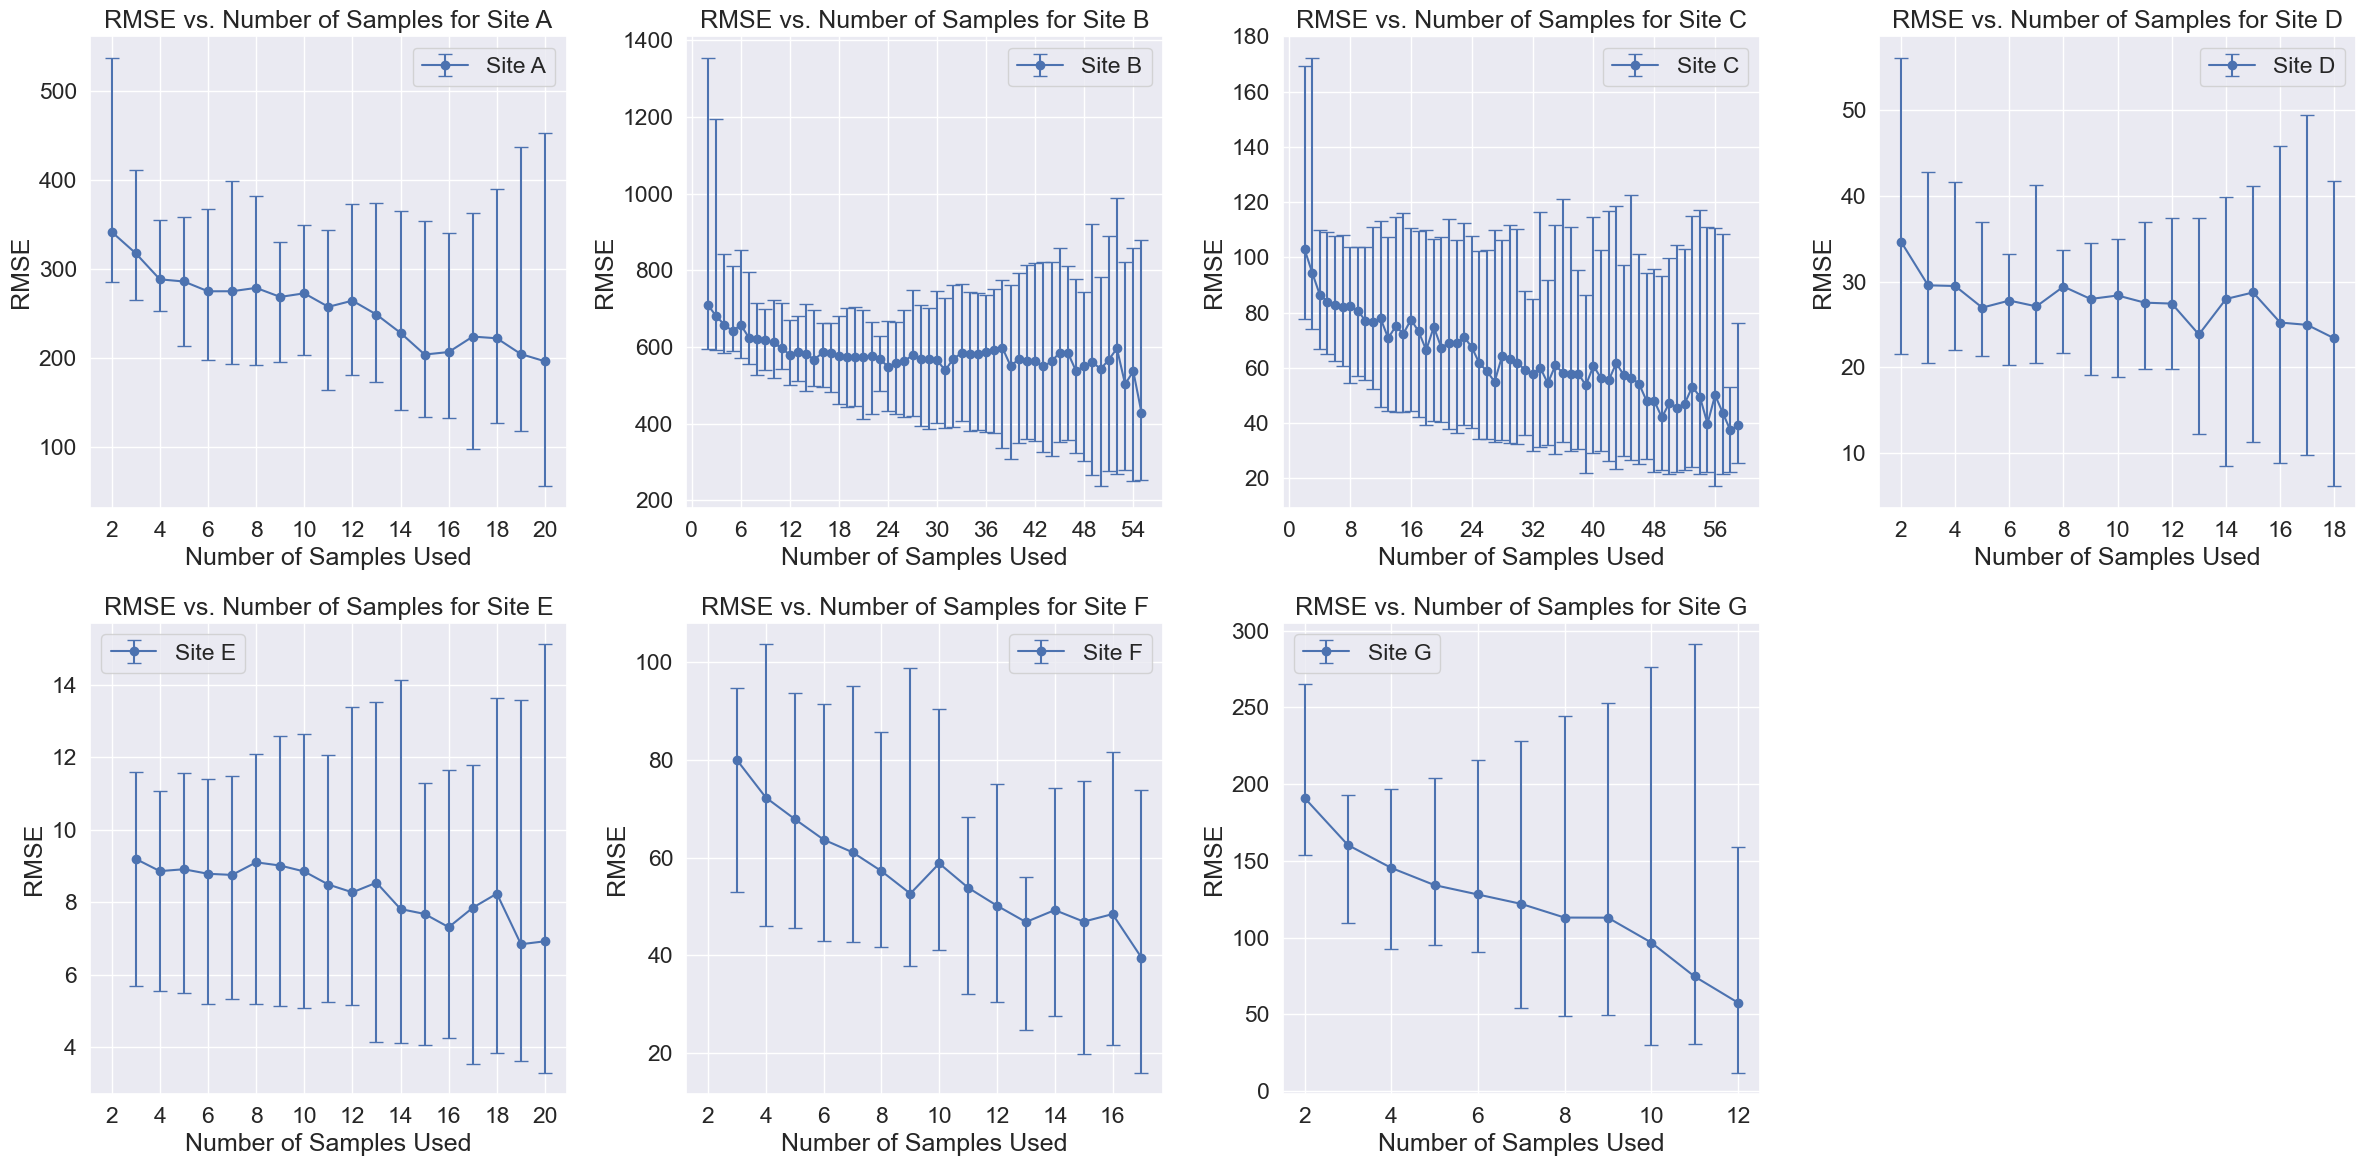

In [ ]:
# Plotting the curves with subplots for each site in random_dictionary
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 6))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    print(rmse_mins)
    ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                fmt='-o', capsize=5, label=f'Site {site_id}')
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE vs. Number of Samples for Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Hide any unused subplots if random_dictionary has less than 3 sites
for i in range(len(random_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.show()



## Plot all together with baseline. Random bars are max and min values

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site A, Model D plotted
Site A, Model E plotted
Site A, Model F plotted
Site A, Model G plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site B, Model D plotted
Site B, Model E plotted
Site B, Model F plotted
Site B, Model G plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted
Site C, Model D plotted
Site C, Model E plotted
Site C, Model F plotted
Site C, Model G plotted
Site D, Model A plotted
Site D, Model B plotted
Site D, Model C plotted
Site D, Model D plotted
Site D, Model E plotted
Site D, Model F plotted
Site D, Model G plotted
Site E, Model A plotted
Site E, Model B plotted
Site E, Model C plotted
Site E, Model D plotted
Site E, Model E plotted
Site E, Model F plotted
Site E, Model G plotted
Site F, Model A plotted
Site F, Model B plotted
Site F, Model C plotted
Site F, Model D plotted
Site F, Model E plotted
Site F, Model F plotted
Site F, Model G 

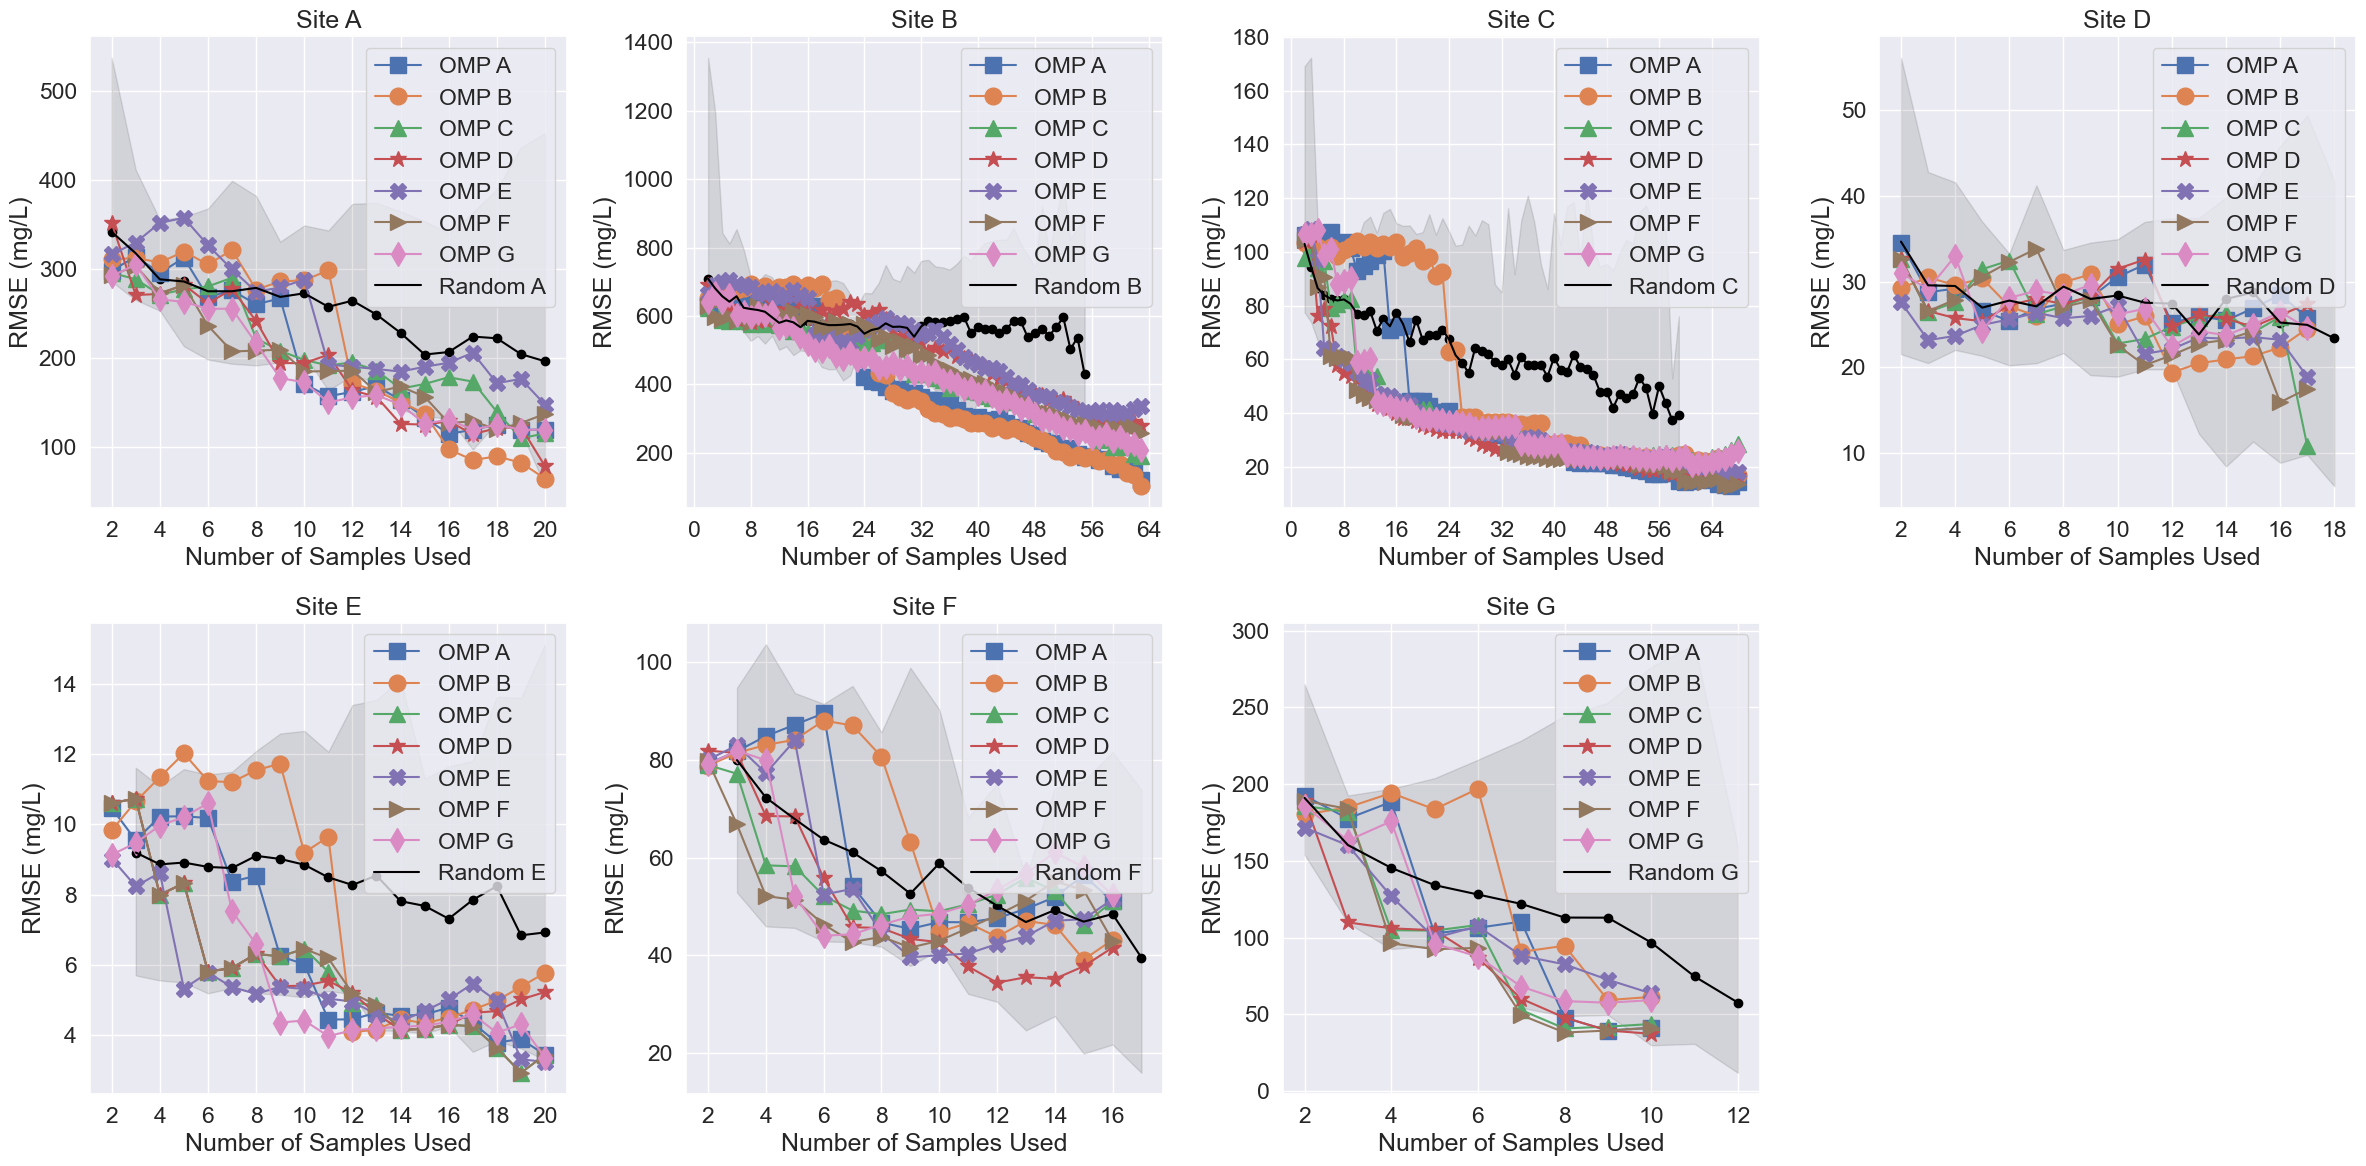

In [ ]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 6))  
axes = axes.flatten() 

for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'OMP {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    # print(rmse_mins)
    # ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                # fmt='-o', capsize=5, label=f'Random {site_id}', color = 'black')
    # Plot the shaded error bounds
    ax.plot(sample_sizes, rmse_means, color='black',label=f'Random {site_id}')
    ax.scatter(sample_sizes, rmse_means, color='black')
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1)
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



# Time series prediction

[363.73223866 363.64559597 363.92438239 ... 359.48885723 359.5724023
 359.34152339]
[337.07773362 337.07773362 337.07773362 ... 337.07773362 337.07773362
 337.07773362]
[363.73223866 363.64559597 363.92438239 ... 359.48885723 359.5724023
 359.34152339]
[220.41289518 220.71449508 221.31591867 ... 219.08295989 219.1272206
 219.05486615]
[220.08681885 220.36834338 220.93448412 ... 218.91151923 218.94172113
 218.89828903]
[12.19238604 11.60230378 10.94175832 ... 18.82734282 18.25680915
 19.36272954]
[216.07429263 216.64633885 214.38453202 ... 205.56125033 206.10739212
 205.72153853]
[172.68543501 173.87797958 169.23740998 ... 153.55054155 154.38923506
 153.79467824]
[216.07429263 216.64633885 214.38453202 ... 205.56125033 206.10739212
 205.72153853]


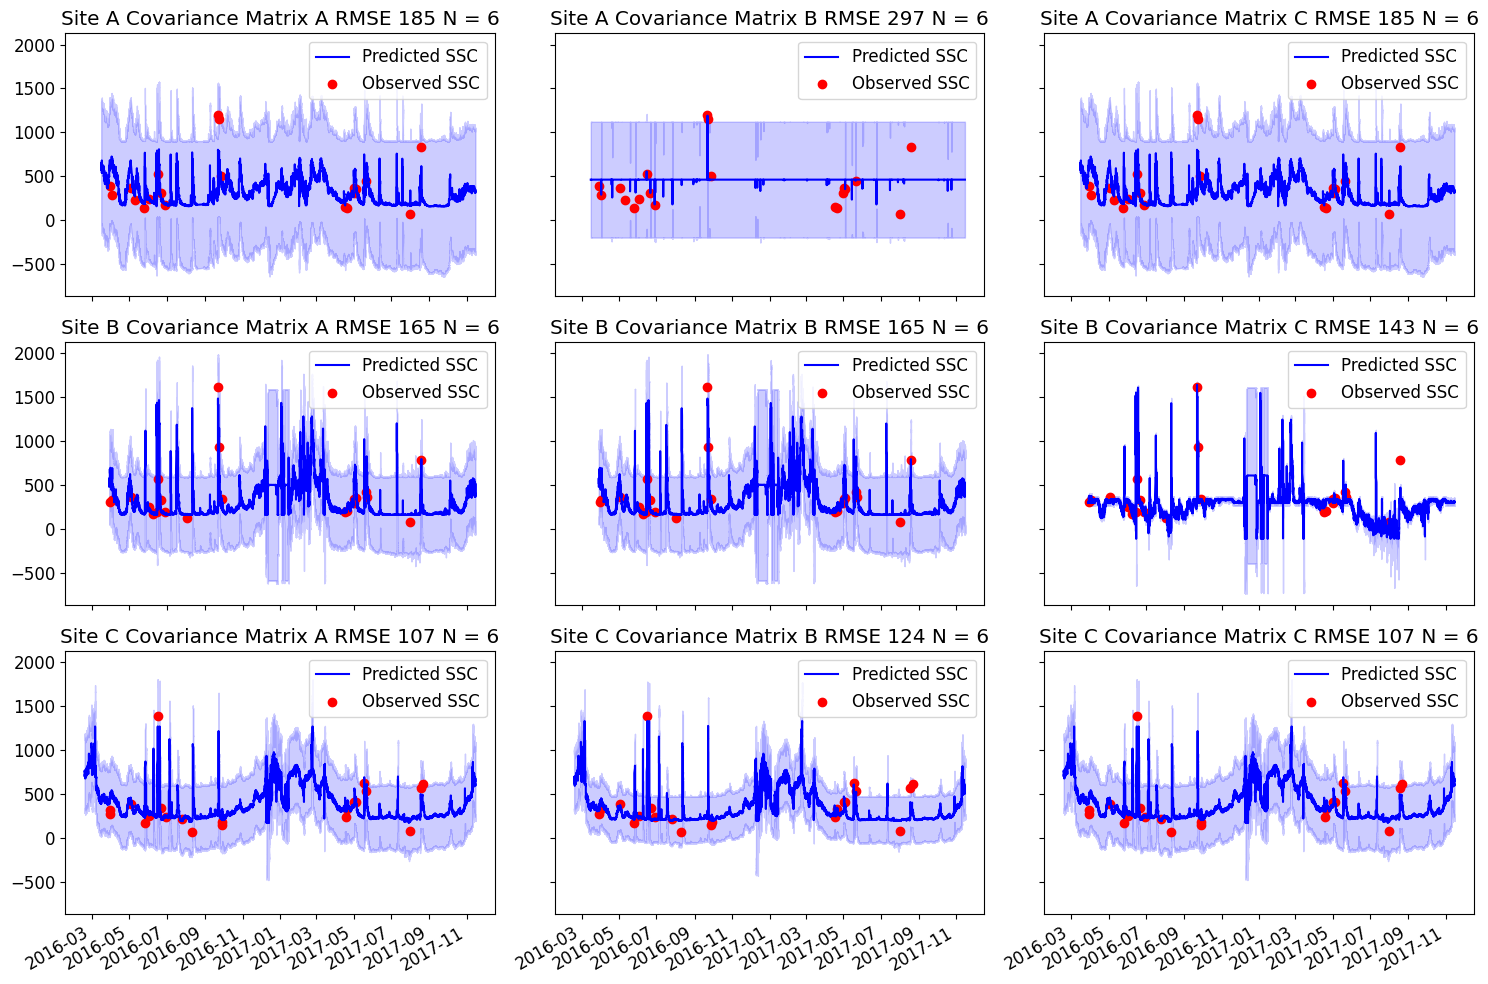

In [ ]:
# Set up the 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
# number samples to use for optimal training
n = 6
# Predict SSC using SAC data from `site_data[ADVM]`
plot_index = 0
for site_id in alpha_site_id:
    for i, cov_id in enumerate(alpha_site_id):
        # site_id = USGS_site_id[id]
        site_data = data_dictionary[site_id]
        advm_data = site_data['ADVM']
        sac_data = advm_data['SAC'].to_numpy()
        datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
        datetime_data = serialTimeToDatetime(datetime_num_data)


        # Use the GP model to predict SSC. This is the GP generated using covariance matrix of a site to select samples of another
        
        GP_model = optimal_dictionary[site_id][cov_id][n]['model']
        rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
        ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)
        print(ssc_std)
        # Plot the predictions
        ax = axes[plot_index]
        ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
        ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)
        
        # Match the sizes of x and y for observed data
        valid_indices = ~np.isnan(site_data['Samples']['SSC'])
        observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
        observed_dates = serialTimeToDatetime(observed_num_dates)
        observed_ssc = site_data['Samples']['SSC'][valid_indices]
        
        ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC')
        ax.set_title(f'Site {site_id} Covariance Matrix {cov_id} RMSE {rmse_opt:.0f} N = {n}')
        ax.legend()

        plot_index += 1

fig.tight_layout()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()


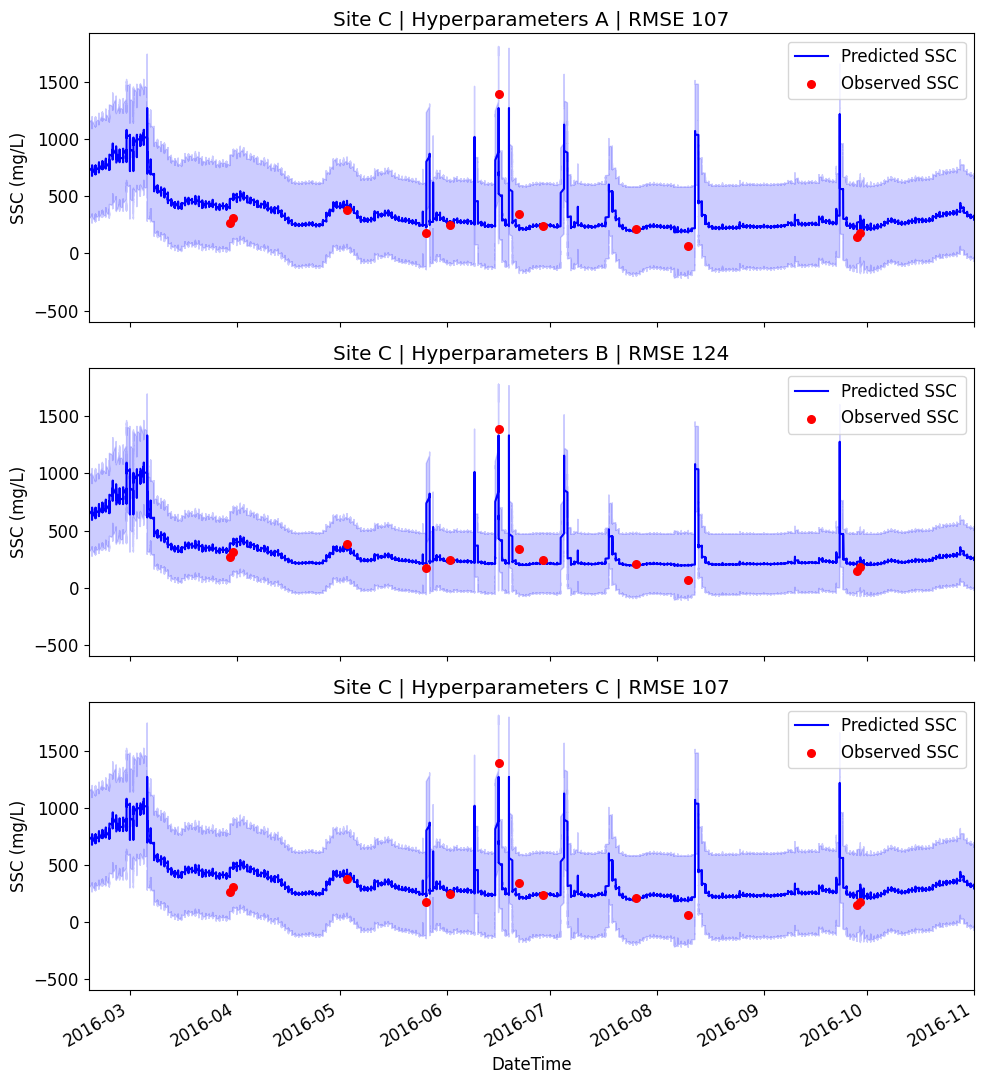

In [ ]:
# Only one column for Site C with different covariance matrices
fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):  # In case there's only one subplot
    axes = [axes]

site_id = 'C'  # Fix to only Site C
n = 6  # Number of samples for optimal training

# Loop over different kernel covariance matrices (cov_id = A, B, C, etc.)
for i, cov_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]
    advm_data = site_data['ADVM']
    sac_data = advm_data['SAC'].to_numpy()
    datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
    datetime_data = serialTimeToDatetime(datetime_num_data)
    
    # GP model trained with samples from cov_id applied to Site C
    GP_model = optimal_dictionary[site_id][cov_id][n]['model']
    rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
    ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)

    # Plotting
    ax = axes[i]
    ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
    ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)

    # Observed data
    valid_indices = ~np.isnan(site_data['Samples']['SSC'])
    observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
    observed_dates = serialTimeToDatetime(observed_num_dates)

    observed_ssc = site_data['Samples']['SSC'][valid_indices]
    ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC', s=30, zorder=10)

    ax.set_title(f'Site {site_id} | Hyperparameters {cov_id} | RMSE {rmse_opt:.0f}')
    ax.legend()
    ax.set_xlabel("DateTime")
    
    ax.set_ylabel("SSC (mg/L)")


# Set x-axis limit to the November 2016
date_cutoff = datetime(2016, 11, 1)
ax.set_xlim([datetime_data[0], date_cutoff])
fig.autofmt_xdate()
fig.tight_layout()
# plt.savefig('figures/Site3_SSC.png', dpi=500)
plt.show()
